## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/minimal_menace')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/minimal_menace.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2023-10-05 21:25:42.838813


{1: 24.0,
 5: 25.1,
 10: 25.9,
 20: 26.7,
 30: 27.8,
 40: 29.4,
 50: 31.2,
 60: 33.1,
 70: 35.1,
 80: 37.5,
 90: 40.8,
 95: 43.9,
 99: 50.00100000000002}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

Cache from: 2023-09-25 05:38:16.758663


{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.2,
 99: 9.5}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2023-10-02 12:51:00.893122


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=4.04, lognorm_sd=3.21, norm_mean=1.15, norm_sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37)},
 'robotics': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.05:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.6:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.8:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    frac = 1 / (4*K) if frac < (1 / (4*K)) else frac
    gpd_frac = 1 / (4*K) if gdp_frac < (1 / (4*K)) else gdp_frac
    return {'total_frac': gdp_frac, 'compute_frac': frac}


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.lognorm(18, 19),  # https://www.lesswrong.com/posts/AfH2oPHCApdKicM4m/two-year-update-on-my-personal-ai-timelines#Making_a_one_time_upward_adjustment_for__2020_FLOP_____ starts at 18, now there are H100 chips that are ~3x better. Also ~1.2x doublings since A100 came out.
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'], # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 8.5, lclip=0.9),
             '2025_spend_doubling_time': sq.norm(0.94, 1.02, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

#### Total % of GDP spent on entire project

In [7]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 59798.69it/s]


{1: 0.00034,
 5: 0.00079,
 10: 0.00102,
 20: 0.00115,
 30: 0.00125,
 40: 0.00133,
 50: 0.00143,
 60: 0.00162,
 70: 0.00264,
 80: 0.00678,
 90: 0.01156,
 95: 0.01445,
 99: 0.01966}

In [8]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.034%',
 5: '0.079%',
 10: '0.102%',
 20: '0.115%',
 30: '0.125%',
 40: '0.133%',
 50: '0.143%',
 60: '0.162%',
 70: '0.264%',
 80: '0.678%',
 90: '1.156%',
 95: '1.445%',
 99: '1.966%'}

In [9]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '8 billion',
 5: '18 billion',
 10: '23 billion',
 20: '26 billion',
 30: '29 billion',
 40: '31 billion',
 50: '33 billion',
 60: '37 billion',
 70: '61 billion',
 80: '156 billion',
 90: '266 billion',
 95: '332 billion',
 99: '452 billion'}

#### Total GDP spent on compute for largest model

In [10]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1084303.81it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00028,
 40: 0.00037,
 50: 0.00047,
 60: 0.00065,
 70: 0.00097,
 80: 0.0017,
 90: 0.00355,
 95: 0.00574,
 99: 0.01117}

In [11]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.025%',
 5: '0.025%',
 10: '0.025%',
 20: '0.025%',
 30: '0.028%',
 40: '0.037%',
 50: '0.047%',
 60: '0.065%',
 70: '0.097%',
 80: '0.17%',
 90: '0.355%',
 95: '0.574%',
 99: '1.117%'}

In [12]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6 billion',
 5: '6 billion',
 10: '6 billion',
 20: '6 billion',
 30: '7 billion',
 40: '8 billion',
 50: '11 billion',
 60: '15 billion',
 70: '22 billion',
 80: '39 billion',
 90: '82 billion',
 95: '132 billion',
 99: '257 billion'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 38.8 log FLOP (~631 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.0 log FLOP (~895 quadrillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~7 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~251 million). This doubles every 2.4 years to a max of 0.600574% of GDP (initially ~138 billion 2022$USD). GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.4 max log FLOP available - TAI takes 38.8 log FLOP - log 2023$USD 20.8 to buy TAI vs. willingness to pay log $ 8.4 - 18.0 log FLOP per $ (Total FLOP 26.4 vs. Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP available - TAI takes 38.5 log FLOP - log 2023$USD 20.4 to buy TAI vs. willingness to pay log $ 8.5 - 18.1 log FLOP per $ (Total FLOP 26.6 vs. Effective 2023-logFLOP: 26.9)
Year: 2025 - 26.9 max log FLOP available - TA

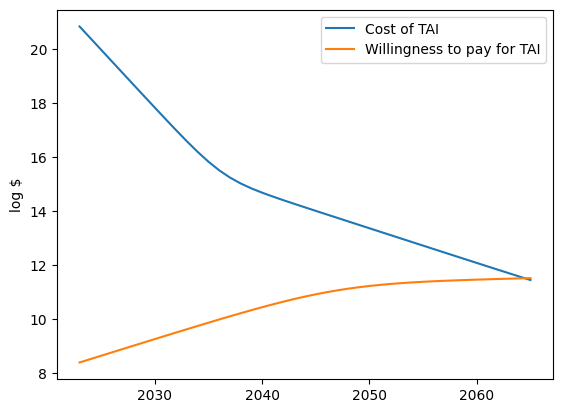

-
-
## SAMPLE RUN 2 ##
It takes 24.0 log FLOP (~1000 sextillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~253 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~469 million). This doubles every 5.6 years to a max of 0.031401% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.8 max log FLOP available - TAI takes 24.0 log FLOP - log 2023$USD 5.8 to buy TAI vs. willingness to pay log $ 8.6 - 18.2 log FLOP per $ (Total FLOP 26.8 vs. Effective 2023-logFLOP: 26.8)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
-- robo

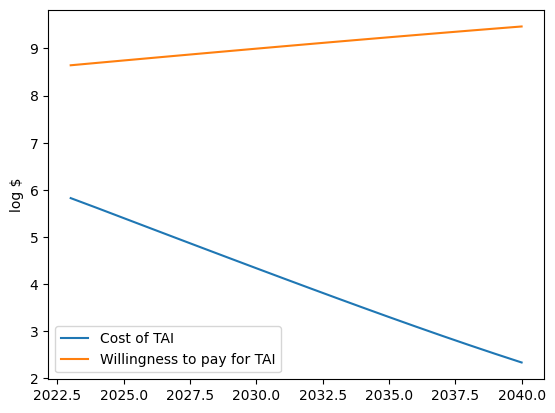

-
-
## SAMPLE RUN 3 ##
It takes 29.0 log FLOP (~100 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~20 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~463 million). This doubles every 3.8 years to a max of 0.026725% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.7 max log FLOP available - TAI takes 29.0 log FLOP - log 2023$USD 10.9 to buy TAI vs. willingness to pay log $ 8.6 - 18.1 log FLOP per $ (Total FLOP 26.7 vs. Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP available - TAI takes 28.9 log FLOP - log 2023$USD 10.7 to buy TAI vs. willingness to pay log $ 8.7 - 18.2 log FLOP per $ (Total FLOP 26.9 vs. Effective 2023-logFLOP: 27.0)
Year: 2025 - 27.1 max log FLOP available - TAI takes 28

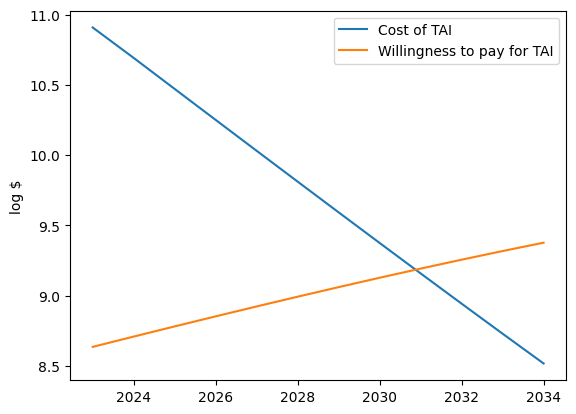

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.31it/s]


Shuffling data...
Writing data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 615.07it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2028',
 '10%: 2030',
 '15%: 2032',
 '20%: 2033',
 '25%: 2035',
 '35%: 2037',
 '50%: 2042',
 '60%: 2047',
 '75%: 2063',
 '80%: 2077',
 '90%: >2123',
 '95%: >2123']
(Mean: 2057)
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 5 years from now',
 '10%: 7 years from now',
 '15%: 9 years from now',
 '20%: 10 years from now',
 '25%: 12 years from now',
 '35%: 14 years from now',
 '50%: 19 years from now',
 '60%: 24 years from now',
 '75%: 40 years from now',
 '80%: 54 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 34 years from now)
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.4%
2024-2025: 0.8%
2026-2027: 2.3%
2028-2029: 5.8%
2030-2034: 16.9%
2035-2039: 18.2%
2040-2049: 20.6%
2050-2059: 9.1%
2060-2069: 5.4%
2070-2079: 2.3%
2080-2089: 1.5%
2090-2099: 0.6%


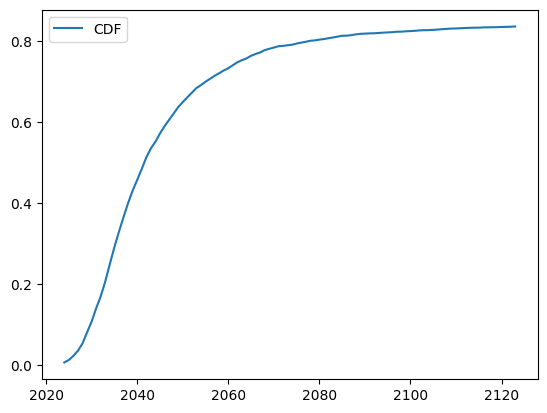

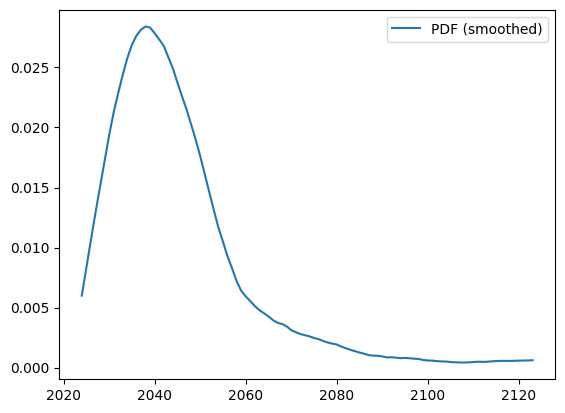

-
-
## TAI FLOP SIZE ##
{1: 24.0,
 5: 25.1,
 10: 25.9,
 20: 26.8,
 30: 27.8,
 40: 29.2,
 50: 31.2,
 60: 33.1,
 70: 35.6,
 80: 38.4,
 90: 41.6,
 95: 44.8,
 99: 51.9}
(Mean: 32.6)


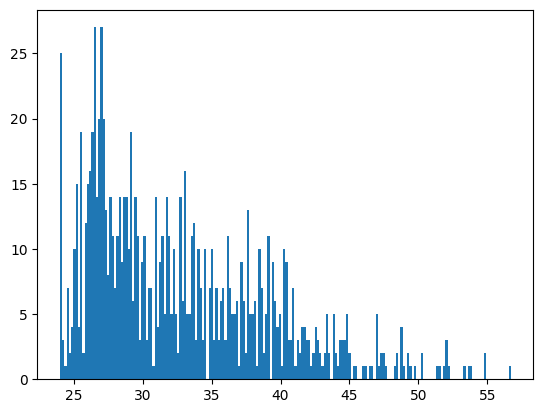

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 19.6,
 5: 14.6,
 10: 12.2,
 20: 10.2,
 30: 8.6,
 40: 7.6,
 50: 6.6,
 60: 5.8,
 70: 5.2,
 80: 4.4,
 90: 3.7,
 95: 3.1,
 99: 2.4}
(Mean: 7.5)


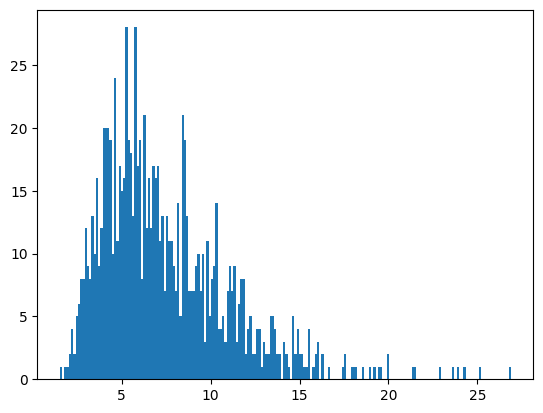

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR ##
{1: 17.8,
 5: 18.0,
 10: 18.1,
 20: 18.2,
 30: 18.3,
 40: 18.4,
 50: 18.5,
 60: 18.6,
 70: 18.7,
 80: 18.8,
 90: 18.9,
 95: 19.0,
 99: 19.3}
(Mean: 18.5)


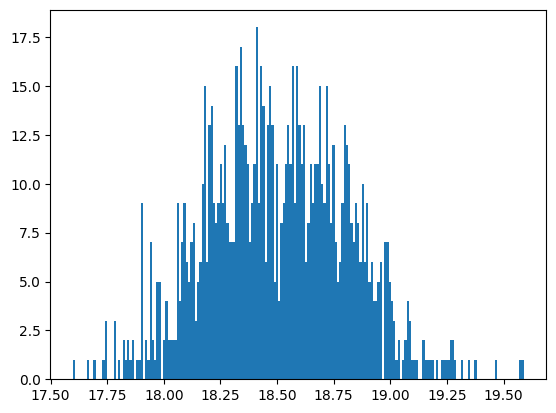

-
-
## FLOP HALVING RATE ##
{1: 3.3,
 5: 3.0,
 10: 2.9,
 20: 2.8,
 30: 2.7,
 40: 2.6,
 50: 2.5,
 60: 2.4,
 70: 2.3,
 80: 2.3,
 90: 2.1,
 95: 2.0,
 99: 1.8}
(Mean: 2.5)


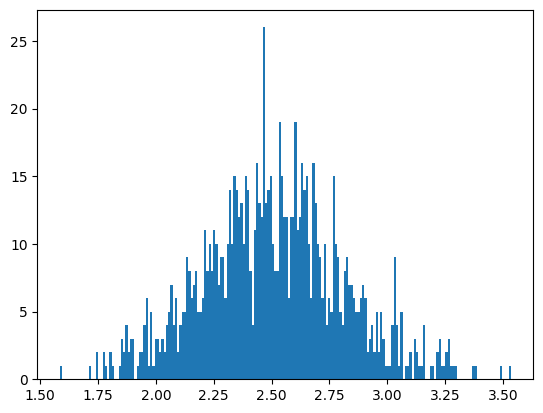

-
-
## MAX FLOP PER DOLLAR ##
{1: 19.9,
 5: 21.0,
 10: 21.5,
 20: 22.3,
 30: 22.7,
 40: 23.2,
 50: 23.6,
 60: 23.9,
 70: 24.4,
 80: 24.8,
 90: 25.5,
 95: 26.1,
 99: 26.8}
(Mean: 23.5)


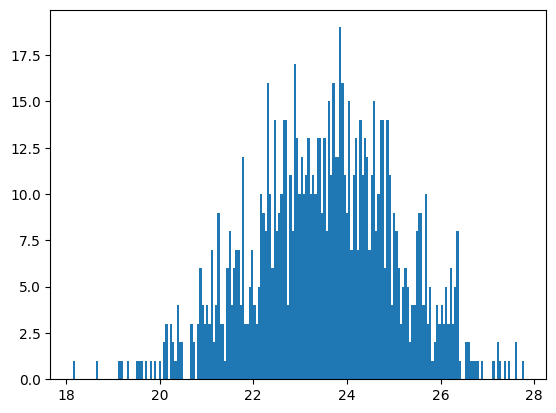

-
-
## INITIAL PAY ##
{1: 8.0,
 5: 8.2,
 10: 8.2,
 20: 8.4,
 30: 8.5,
 40: 8.6,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.3,
 99: 9.5}
(Mean: 8.7)


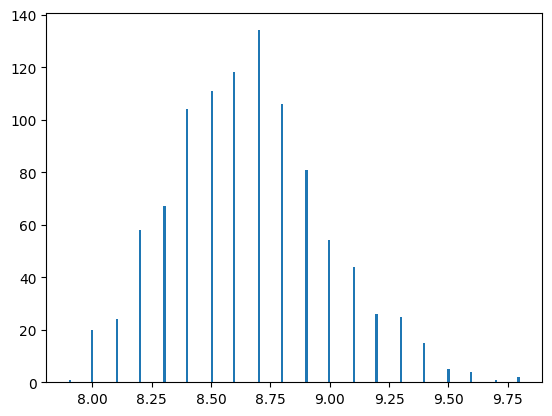

-
-
## GDP GROWTH ##
{1: 1.0,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}
(Mean: 1.0)


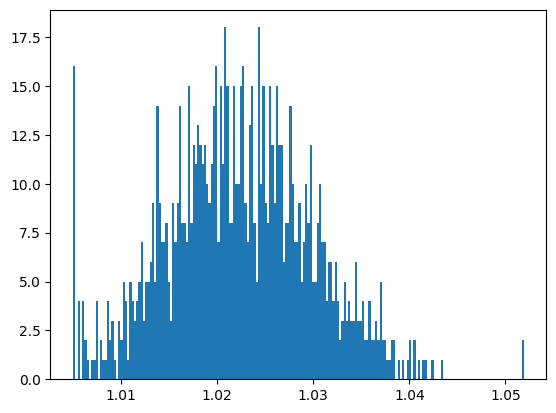

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00028,
 40: 0.00036,
 50: 0.00048,
 60: 0.00063,
 70: 0.00086,
 80: 0.00149,
 90: 0.00332,
 95: 0.00509,
 99: 0.01371}
(Mean: 0.0)


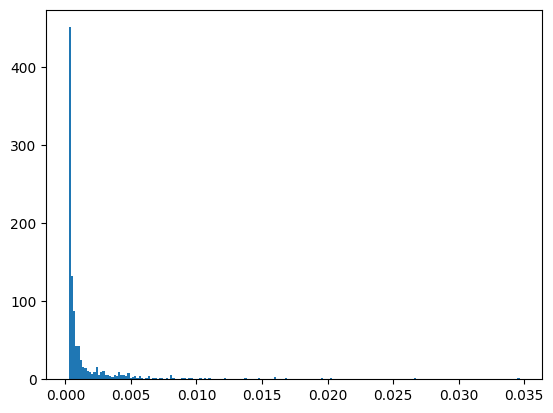

-
-
## SPEND DOUBLING TIME ##
{1: 13.9,
 5: 8.1,
 10: 6.2,
 20: 4.8,
 30: 4.0,
 40: 3.3,
 50: 2.8,
 60: 2.4,
 70: 1.9,
 80: 1.6,
 90: 1.2,
 95: 0.9,
 99: 0.9}
(Mean: 3.5)


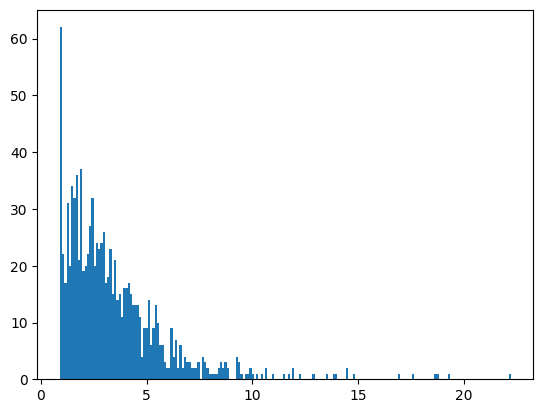

-
-
-
-
## GDP Over Time ##


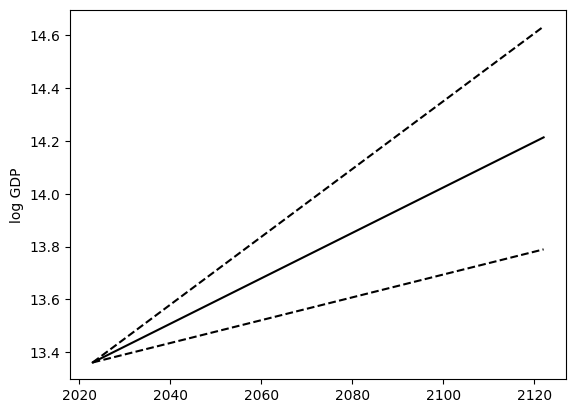

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

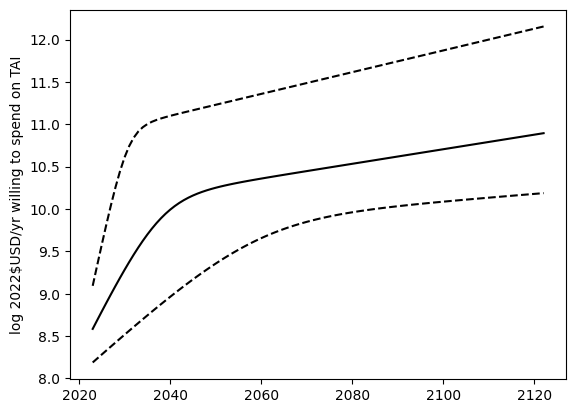

Year: 2023 - willingness log 2022$USD per year 8.6 (~384 million) 90% CI 8.2 (~154 million) - 9.1 (~1 billion)
Year: 2024 - willingness log 2022$USD per year 8.7 (~488 million) 90% CI 8.2 (~172 million) - 9.3 (~2 billion)
Year: 2025 - willingness log 2022$USD per year 8.8 (~618 million) 90% CI 8.3 (~192 million) - 9.6 (~4 billion)
Year: 2026 - willingness log 2022$USD per year 8.9 (~781 million) 90% CI 8.3 (~214 million) - 9.8 (~7 billion)
Year: 2027 - willingness log 2022$USD per year 9.0 (~983 million) 90% CI 8.4 (~238 million) - 10.0 (~11 billion)
Year: 2028 - willingness log 2022$USD per year 9.1 (~1 billion) 90% CI 8.4 (~265 million) - 10.3 (~18 billion)
Year: 2029 - willingness log 2022$USD per year 9.2 (~2 billion) 90% CI 8.5 (~295 million) - 10.4 (~28 billion)
Year: 2030 - willingness log 2022$USD per year 9.3 (~2 billion) 90% CI 8.5 (~328 million) - 10.6 (~41 billion)
Year: 2031 - willingness log 2022$USD per year 9.4 (~2 billion) 90% CI 8.6 (~365 million) - 10.7 (~55 billion)

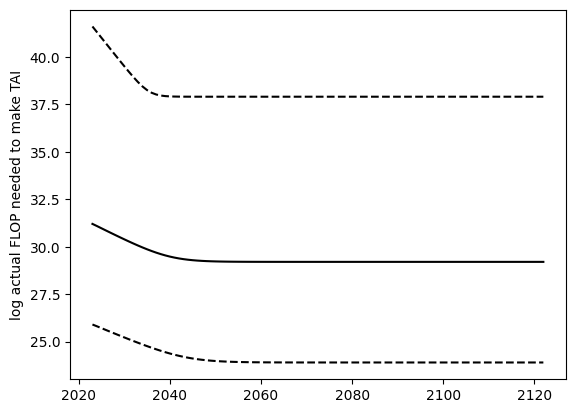

Year: 2023 - log FLOP needed for TAI 31.2 (~16 nonillion) 90% CI 25.9 (~79 septillion) - 41.6 (~398 million decillion)
Year: 2024 - log FLOP needed for TAI 31.1 (~12 nonillion) 90% CI 25.8 (~64 septillion) - 41.3 (~199 million decillion)
Year: 2025 - log FLOP needed for TAI 31.0 (~9 nonillion) 90% CI 25.7 (~51 septillion) - 41.0 (~100 million decillion)
Year: 2026 - log FLOP needed for TAI 30.8 (~7 nonillion) 90% CI 25.6 (~41 septillion) - 40.7 (~50 million decillion)
Year: 2027 - log FLOP needed for TAI 30.7 (~5 nonillion) 90% CI 25.5 (~32 septillion) - 40.4 (~25 million decillion)
Year: 2028 - log FLOP needed for TAI 30.6 (~4 nonillion) 90% CI 25.4 (~26 septillion) - 40.1 (~13 million decillion)
Year: 2029 - log FLOP needed for TAI 30.5 (~3 nonillion) 90% CI 25.3 (~21 septillion) - 39.8 (~6 million decillion)
Year: 2030 - log FLOP needed for TAI 30.4 (~2 nonillion) 90% CI 25.2 (~17 septillion) - 39.5 (~3 million decillion)
Year: 2031 - log FLOP needed for TAI 30.3 (~2 nonillion) 90% 

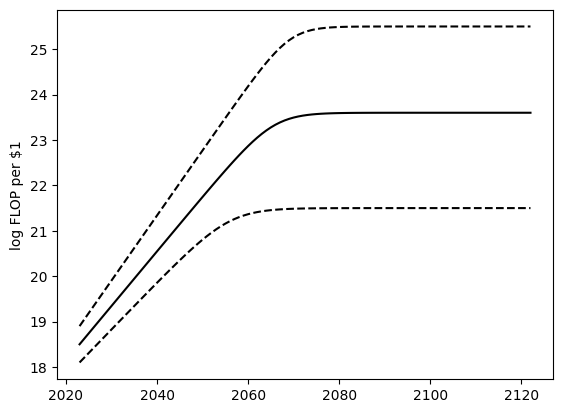

Year: 2023 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.1 (~1 quintillion) - 18.9 (~8 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.6 (~4 quintillion) 90% CI 18.2 (~2 quintillion) - 19.0 (~11 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.7 (~6 quintillion) 90% CI 18.3 (~2 quintillion) - 19.2 (~15 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.9 (~7 quintillion) 90% CI 18.4 (~3 quintillion) - 19.3 (~21 quintillion)
Year: 2027 - log FLOP per 2022$1USD 19.0 (~10 quintillion) 90% CI 18.5 (~3 quintillion) - 19.5 (~30 quintillion)
Year: 2028 - log FLOP per 2022$1USD 19.1 (~13 quintillion) 90% CI 18.6 (~4 quintillion) - 19.6 (~41 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.2 (~17 quintillion) 90% CI 18.7 (~5 quintillion) - 19.8 (~58 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.3 (~22 quintillion) 90% CI 18.8 (~7 quintillion) - 19.9 (~80 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.5 (~29 quintillion) 90% CI 18.9 (~8 quintillion) - 20.0 (~111 

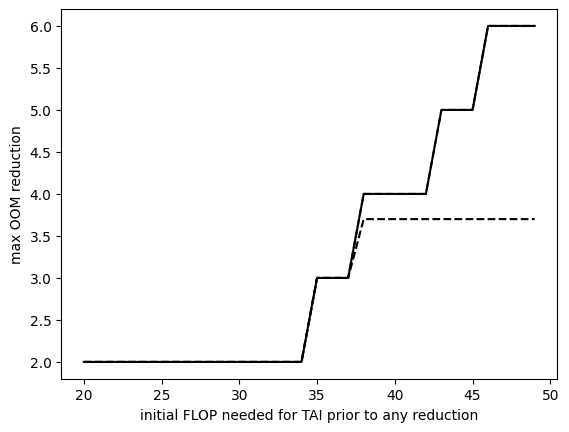

TAI log FLOP 20 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

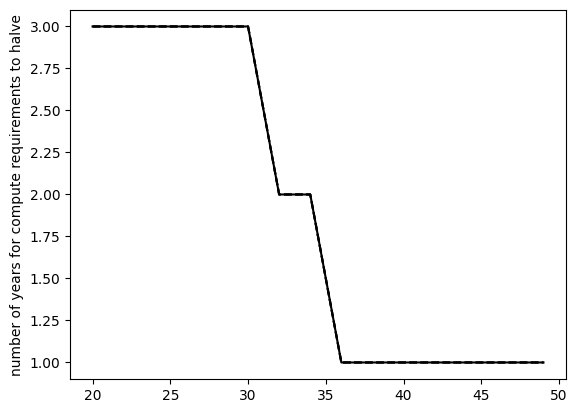

TAI log FLOP 20 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (90% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FL

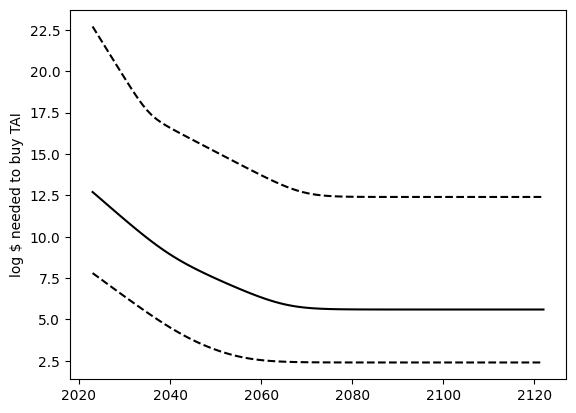

Year: 2023 - 12.7 log 2022$USD to buy TAI (~5 trillion) 90% CI 7.8 (~63 million) - 22.7 (~50 sextillion)
Year: 2024 - 12.5 log 2022$USD to buy TAI (~3 trillion) 90% CI 7.6 (~40 million) - 22.3 (~18 sextillion)
Year: 2025 - 12.2 log 2022$USD to buy TAI (~2 trillion) 90% CI 7.4 (~25 million) - 21.8 (~6 sextillion)
Year: 2026 - 12.0 log 2022$USD to buy TAI (~971 billion) 90% CI 7.2 (~16 million) - 21.4 (~2 sextillion)
Year: 2027 - 11.7 log 2022$USD to buy TAI (~562 billion) 90% CI 7.0 (~10 million) - 20.9 (~839 quintillion)
Year: 2028 - 11.5 log 2022$USD to buy TAI (~326 billion) 90% CI 6.8 (~6 million) - 20.5 (~303 quintillion)
Year: 2029 - 11.3 log 2022$USD to buy TAI (~189 billion) 90% CI 6.6 (~4 million) - 20.0 (~109 quintillion)
Year: 2030 - 11.0 log 2022$USD to buy TAI (~111 billion) 90% CI 6.4 (~2 million) - 19.6 (~40 quintillion)
Year: 2031 - 10.8 log 2022$USD to buy TAI (~65 billion) 90% CI 6.2 (~2 million) - 19.2 (~15 quintillion)
Year: 2032 - 10.6 log 2022$USD to buy TAI (~38 b

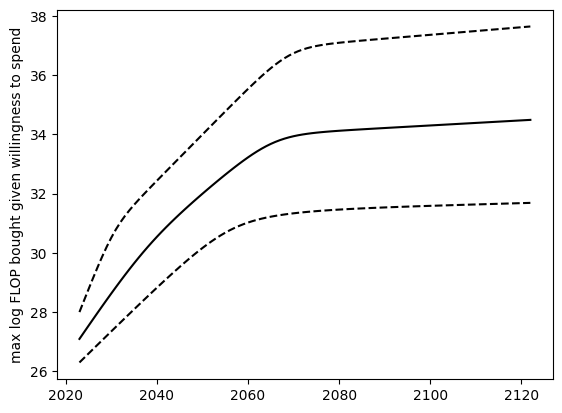

Year: 2023 - max log FLOP 27.1 (~1 octillion) 90% CI 26.3 (~194 septillion) - 28.0 (~10 octillion)
Year: 2024 - max log FLOP 27.3 (~2 octillion) 90% CI 26.4 (~275 septillion) - 28.4 (~24 octillion)
Year: 2025 - max log FLOP 27.5 (~3 octillion) 90% CI 26.6 (~389 septillion) - 28.8 (~59 octillion)
Year: 2026 - max log FLOP 27.8 (~6 octillion) 90% CI 26.7 (~551 septillion) - 29.1 (~140 octillion)
Year: 2027 - max log FLOP 28.0 (~9 octillion) 90% CI 26.9 (~779 septillion) - 29.5 (~329 octillion)
Year: 2028 - max log FLOP 28.2 (~16 octillion) 90% CI 27.0 (~1 octillion) - 29.9 (~745 octillion)
Year: 2029 - max log FLOP 28.4 (~26 octillion) 90% CI 27.2 (~2 octillion) - 30.2 (~2 nonillion)
Year: 2030 - max log FLOP 28.6 (~42 octillion) 90% CI 27.3 (~2 octillion) - 30.5 (~3 nonillion)
Year: 2031 - max log FLOP 28.8 (~69 octillion) 90% CI 27.5 (~3 octillion) - 30.8 (~6 nonillion)
Year: 2032 - max log FLOP 29.0 (~111 octillion) 90% CI 27.6 (~4 octillion) - 31.0 (~11 nonillion)
Year: 2033 - max lo

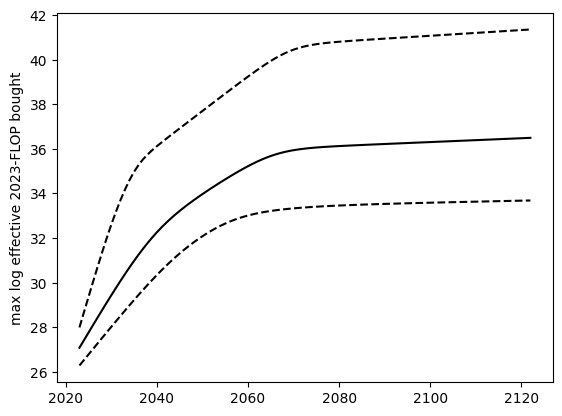

Year: 2023 - max log effective 2023-FLOP 27.1 (~1 octillion) 90% CI 26.3 (~194 septillion) - 28.0 (~10 octillion)
Year: 2024 - max log effective 2023-FLOP 27.4 (~3 octillion) 90% CI 26.5 (~342 septillion) - 28.7 (~48 octillion)
Year: 2025 - max log effective 2023-FLOP 27.8 (~6 octillion) 90% CI 26.8 (~608 septillion) - 29.4 (~234 octillion)
Year: 2026 - max log effective 2023-FLOP 28.1 (~13 octillion) 90% CI 27.0 (~1 octillion) - 30.0 (~1 nonillion)
Year: 2027 - max log effective 2023-FLOP 28.4 (~28 octillion) 90% CI 27.3 (~2 octillion) - 30.7 (~5 nonillion)
Year: 2028 - max log effective 2023-FLOP 28.8 (~60 octillion) 90% CI 27.5 (~3 octillion) - 31.4 (~24 nonillion)
Year: 2029 - max log effective 2023-FLOP 29.1 (~129 octillion) 90% CI 27.8 (~6 octillion) - 32.0 (~102 nonillion)
Year: 2030 - max log effective 2023-FLOP 29.4 (~274 octillion) 90% CI 28.0 (~11 octillion) - 32.6 (~407 nonillion)
Year: 2031 - max log effective 2023-FLOP 29.8 (~577 octillion) 90% CI 28.3 (~19 octillion) - 3

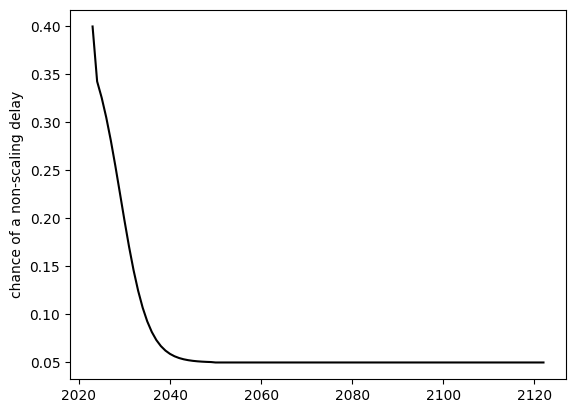

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 34%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 33%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 31%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2033

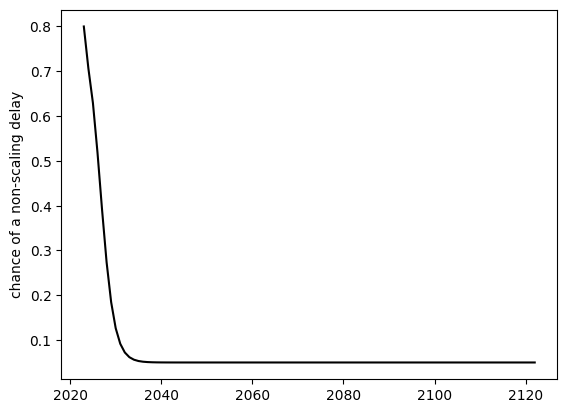

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 71%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 63%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 52%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 -

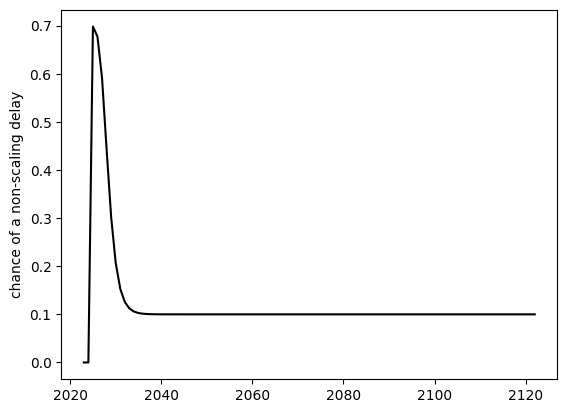

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 68%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 44%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2033 -

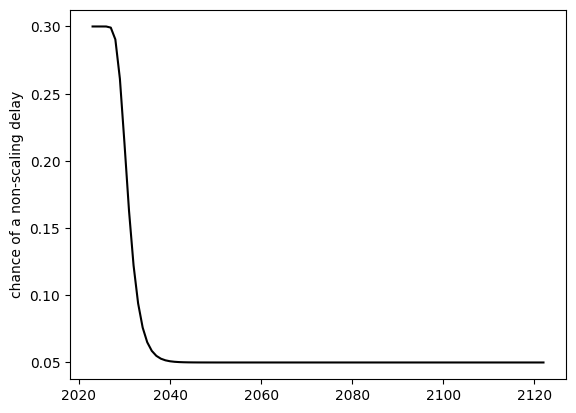

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2033

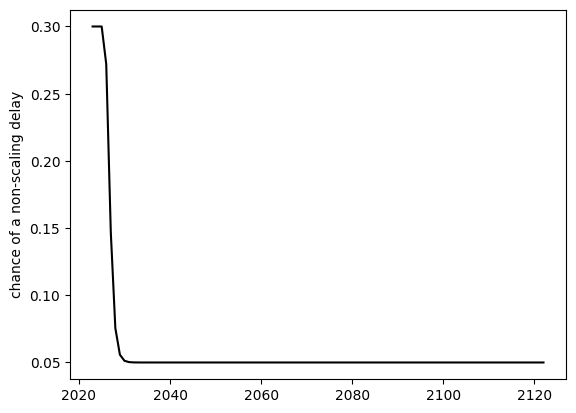

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - ch

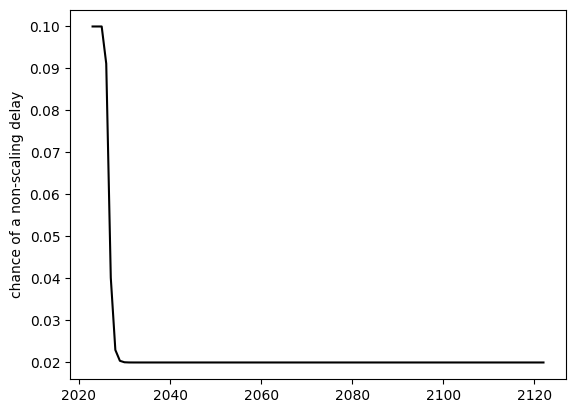

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 4%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2033 - chan

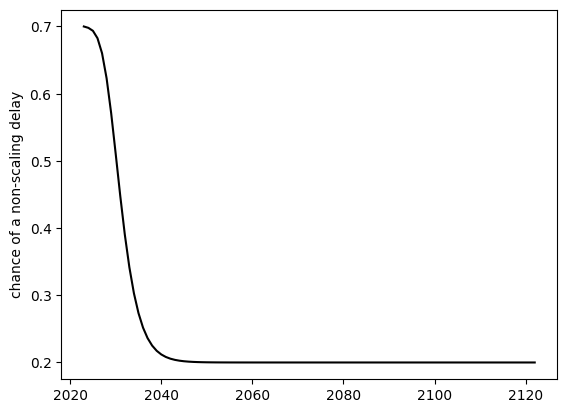

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 69%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 68%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 66%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 62%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 57%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 51%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 45%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2033

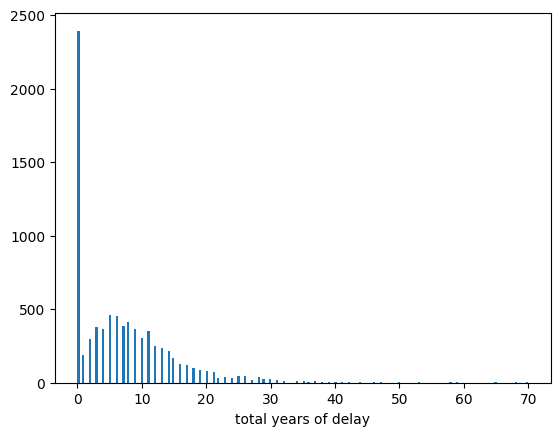

In [13]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 31.3 log FLOP (~20 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~197 million). This doubles every 3.9 years to a max of 0.063808% of GDP (initially ~15 billion 2022$USD). GDP grows at a rate of 1.043x per year.
---
Year: 2023 - 26.8 max log FLOP available - TAI takes 31.3 log FLOP - log 2023$USD 12.8 to buy TAI vs. willingness to pay log $ 8.3 - 18.5 log FLOP per $ (Total FLOP 26.8 vs. Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP available - TAI takes 31.2 log FLOP - log 2023$USD 12.6 to buy TAI vs. willingness to pay log $ 8.4 - 18.6 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.1)
Year: 2025 - 27.2 max log FLOP available - TAI takes 31.

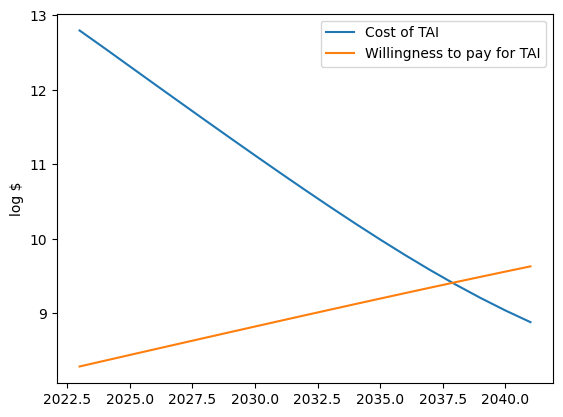

-
-
## SAMPLE RUN 5 ##
It takes 28.3 log FLOP (~20 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~124 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~852 million). This doubles every 2.9 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.3 max log FLOP available - TAI takes 28.3 log FLOP - log 2023$USD 9.9 to buy TAI vs. willingness to pay log $ 8.9 - 18.4 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.5 max log FLOP available - TAI takes 28.2 log FLOP - log 2023$USD 9.7 to buy TAI vs. willingness to pay log $ 9.0 - 18.5 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.6)
Year: 2025 - 27.7 max log FLOP available - TAI takes 28.1 lo

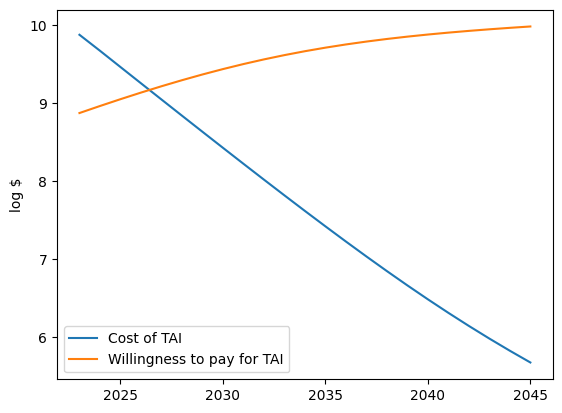

-
-
## SAMPLE RUN 6 ##
It takes 26.6 log FLOP (~398 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~364 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~996 million). This doubles every 2.9 years to a max of 0.98026% of GDP (initially ~225 billion 2022$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.6 max log FLOP available - TAI takes 26.6 log FLOP - log 2023$USD 8.0 to buy TAI vs. willingness to pay log $ 9.0 - 18.6 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.6)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
-- robo

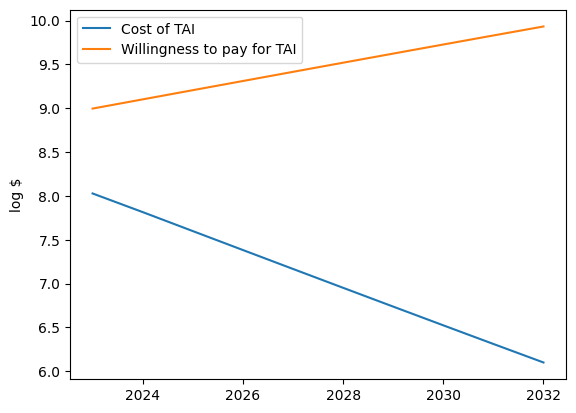

-
-
## SAMPLE RUN 7 ##
It takes 30.2 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 25.8 log FLOP (~63 septillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 1.3 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.0 max log FLOP available - TAI takes 30.2 log FLOP - log 2023$USD 11.8 to buy TAI vs. willingness to pay log $ 8.6 - 18.4 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.3 max log FLOP available - TAI takes 30.1 log FLOP - log 2023$USD 11.6 to buy TAI vs. willingness to pay log $ 8.8 - 18.5 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.5)
Year: 2025 - 27.7 max log FLOP available - TAI takes 30.0 lo

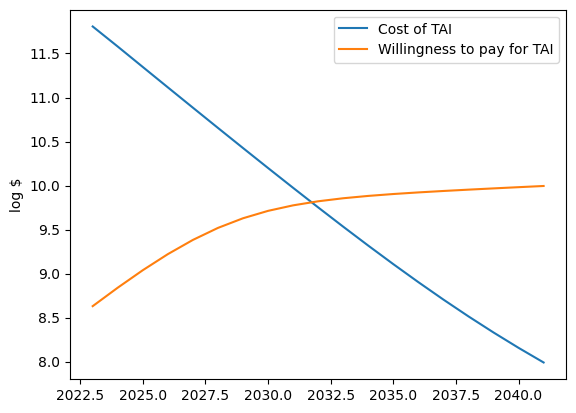

-
-
## SAMPLE RUN 8 ##
It takes 42.0 log FLOP (~1 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~128 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~386 million). This doubles every 3.5 years to a max of 0.057158% of GDP (initially ~13 billion 2022$USD). GDP grows at a rate of 1.038x per year.
---
Year: 2023 - 26.9 max log FLOP available - TAI takes 42.0 log FLOP - log 2023$USD 23.7 to buy TAI vs. willingness to pay log $ 8.6 - 18.3 log FLOP per $ (Total FLOP 26.9 vs. Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP available - TAI takes 41.7 log FLOP - log 2023$USD 23.2 to buy TAI vs. willingness to pay log $ 8.7 - 18.5 log FLOP per $ (Total FLOP 27.1 vs. Effective 2023-logFLOP: 27.4)
Year: 2025 - 27.3 max log FLOP available - TAI ta

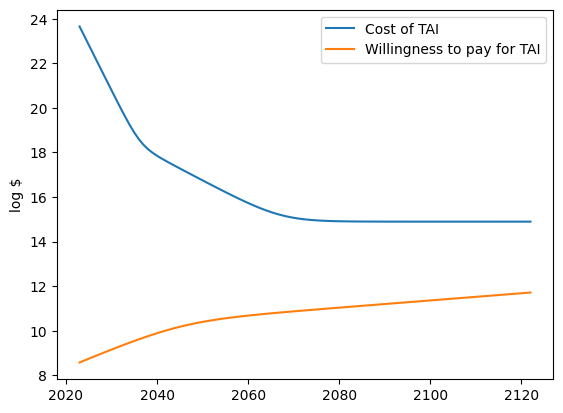

-
-
## SAMPLE RUN 9 ##
It takes 39.4 log FLOP (~3 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~97 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~624 million). This doubles every 7.1 years to a max of 0.232136% of GDP (initially ~53 billion 2022$USD). GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.0 max log FLOP available - TAI takes 39.4 log FLOP - log 2023$USD 21.2 to buy TAI vs. willingness to pay log $ 8.8 - 18.2 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP available - TAI takes 39.1 log FLOP - log 2023$USD 20.7 to buy TAI vs. willingness to pay log $ 8.8 - 18.4 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.5)
Year: 2025 - 27.3 max log FLOP available - TAI tak

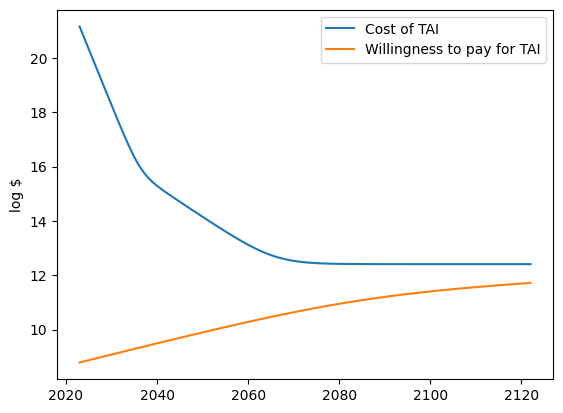

-
-
## SAMPLE RUN 10 ##
It takes 43.0 log FLOP (~10 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~109 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~613 million). This doubles every 3.3 years to a max of 0.092397% of GDP (initially ~21 billion 2022$USD). GDP grows at a rate of 1.039x per year.
---
Year: 2023 - 27.3 max log FLOP available - TAI takes 43.0 log FLOP - log 2023$USD 24.5 to buy TAI vs. willingness to pay log $ 8.8 - 18.5 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.5 max log FLOP available - TAI takes 42.7 log FLOP - log 2023$USD 24.0 to buy TAI vs. willingness to pay log $ 8.9 - 18.7 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.8)
Year: 2025 - 27.8 max log FLOP available - TAI 

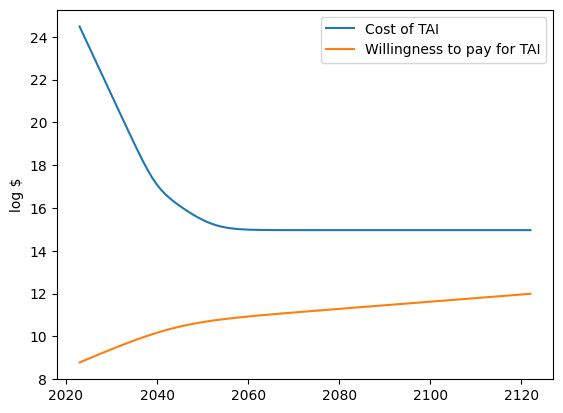

-
-
## SAMPLE RUN 11 ##
It takes 29.4 log FLOP (~251 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~9 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~387 million). This doubles every 1.7 years to a max of 0.063211% of GDP (initially ~15 billion 2022$USD). GDP grows at a rate of 1.039x per year.
---
Year: 2023 - 27.5 max log FLOP available - TAI takes 29.4 log FLOP - log 2023$USD 10.5 to buy TAI vs. willingness to pay log $ 8.6 - 18.9 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.8 max log FLOP available - TAI takes 29.3 log FLOP - log 2023$USD 10.2 to buy TAI vs. willingness to pay log $ 8.8 - 19.1 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 27.9)
Year: 2025 - 28.1 max log FLOP available - TAI takes 2

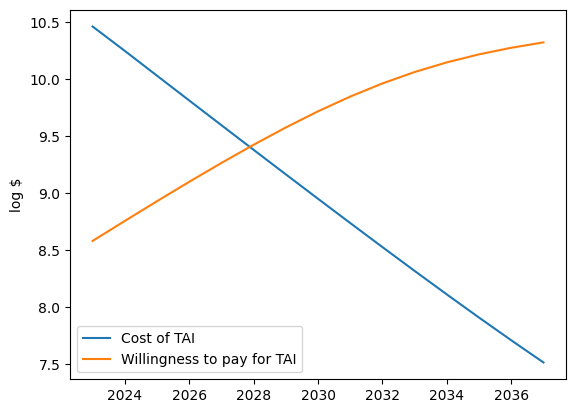

-
-
## SAMPLE RUN 12 ##
It takes 37.0 log FLOP (~10 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.0 log FLOP (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~155 million). This doubles every 2.2 years to a max of 0.034622% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.2 max log FLOP available - TAI takes 37.0 log FLOP - log 2023$USD 19.0 to buy TAI vs. willingness to pay log $ 8.2 - 18.0 log FLOP per $ (Total FLOP 26.2 vs. Effective 2023-logFLOP: 26.2)
Year: 2024 - 26.5 max log FLOP available - TAI takes 36.7 log FLOP - log 2023$USD 18.6 to buy TAI vs. willingness to pay log $ 8.3 - 18.1 log FLOP per $ (Total FLOP 26.5 vs. Effective 2023-logFLOP: 26.8)
Year: 2025 - 26.7 max log FLOP available - TAI 

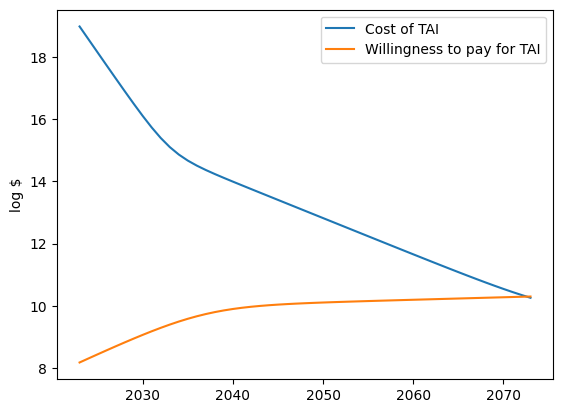

-
-
## SAMPLE RUN 13 ##
It takes 33.9 log FLOP (~8 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~376 million). This doubles every 2.0 years to a max of 0.029992% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 27.3 max log FLOP available - TAI takes 33.9 log FLOP - log 2023$USD 15.2 to buy TAI vs. willingness to pay log $ 8.6 - 18.7 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.6 max log FLOP available - TAI takes 33.8 log FLOP - log 2023$USD 14.9 to buy TAI vs. willingness to pay log $ 8.7 - 18.9 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.7)
Year: 2025 - 27.8 max log FLOP available - TAI takes 33.6

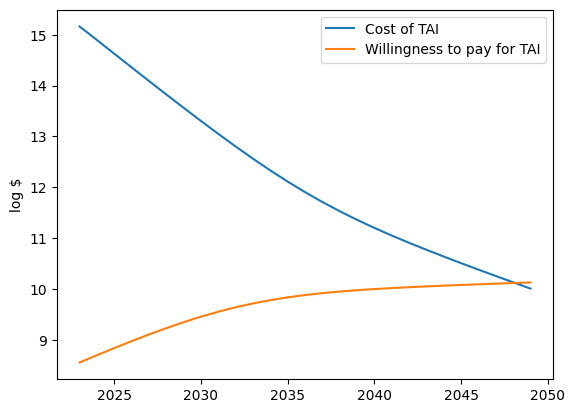

-
-
## SAMPLE RUN 14 ##
It takes 34.0 log FLOP (~10 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~500 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~624 million). This doubles every 2.6 years to a max of 0.248116% of GDP (initially ~57 billion 2022$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.5 max log FLOP available - TAI takes 34.0 log FLOP - log 2023$USD 15.3 to buy TAI vs. willingness to pay log $ 8.8 - 18.7 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.7 max log FLOP available - TAI takes 33.9 log FLOP - log 2023$USD 15.1 to buy TAI vs. willingness to pay log $ 8.9 - 18.8 log FLOP per $ (Total FLOP 27.7 vs. Effective 2023-logFLOP: 27.9)
Year: 2025 - 27.9 max log FLOP available - TAI takes 

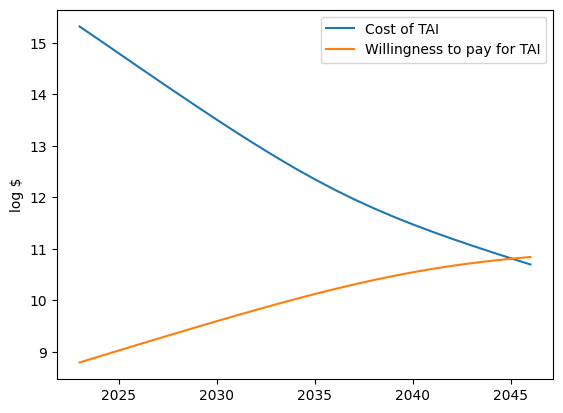

-
-
## SAMPLE RUN 15 ##
It takes 24.0 log FLOP (~1000 sextillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.0 log FLOP (~1 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 26.3 log FLOP (~191 septillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~885 million). This doubles every 6.2 years to a max of 0.03358% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.9 max log FLOP available - TAI takes 24.0 log FLOP - log 2023$USD 6.0 to buy TAI vs. willingness to pay log $ 8.9 - 18.0 log FLOP per $ (Total FLOP 26.9 vs. Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 6 years)
-- data p_nonscaling_issue p=0

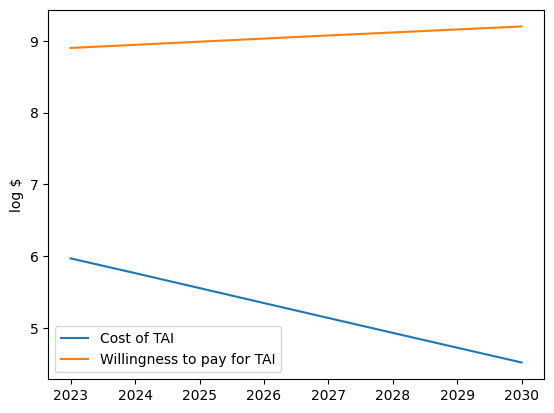

-
-
## SAMPLE RUN 16 ##
It takes 27.9 log FLOP (~8 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~72 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~852 million). This doubles every 3.6 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.1 max log FLOP available - TAI takes 27.9 log FLOP - log 2023$USD 9.7 to buy TAI vs. willingness to pay log $ 8.9 - 18.2 log FLOP per $ (Total FLOP 27.1 vs. Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.3 max log FLOP available - TAI takes 27.8 log FLOP - log 2023$USD 9.5 to buy TAI vs. willingness to pay log $ 8.9 - 18.3 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.4)
Year: 2025 - 27.4 max log FLOP available - TAI takes 27.7 log FL

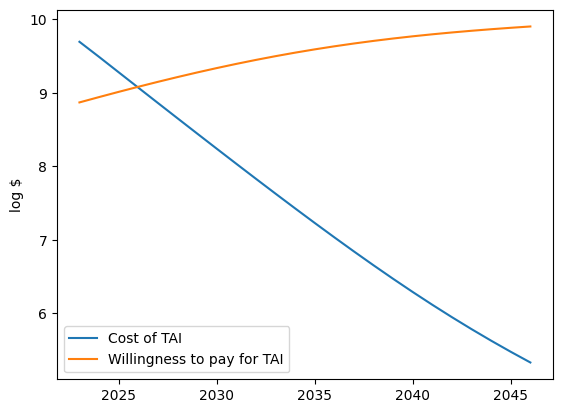

-
-
## SAMPLE RUN 17 ##
It takes 33.0 log FLOP (~1000 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.0 log FLOP (~10 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~374 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~395 million). This doubles every 1.1 years to a max of 0.215526% of GDP (initially ~50 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.6 max log FLOP available - TAI takes 33.0 log FLOP - log 2023$USD 14.0 to buy TAI vs. willingness to pay log $ 8.6 - 19.0 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.6)
Year: 2024 - 28.0 max log FLOP available - TAI takes 32.9 log FLOP - log 2023$USD 13.7 to buy TAI vs. willingness to pay log $ 8.9 - 19.1 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.1)
Year: 2025 - 28.4 max log FLOP available - TAI tak

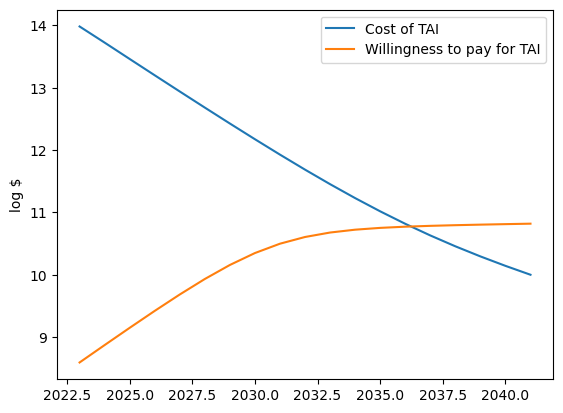

-
-
## SAMPLE RUN 18 ##
It takes 30.9 log FLOP (~8 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~110 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~377 million). This doubles every 3.5 years to a max of 0.030206% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.009x per year.
---
Year: 2023 - 27.0 max log FLOP available - TAI takes 30.9 log FLOP - log 2023$USD 12.4 to buy TAI vs. willingness to pay log $ 8.6 - 18.5 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP available - TAI takes 30.8 log FLOP - log 2023$USD 12.2 to buy TAI vs. willingness to pay log $ 8.6 - 18.6 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.3)
Year: 2025 - 27.4 max log FLOP available - TAI takes 30

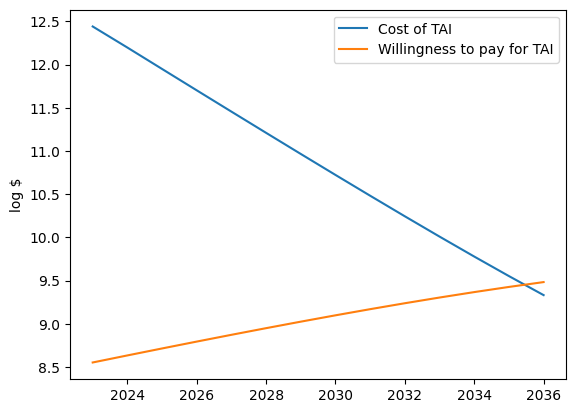

-
-
## SAMPLE RUN 19 ##
It takes 46.6 log FLOP (~40 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 6 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~96 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~315 million). This doubles every 3.2 years to a max of 0.377733% of GDP (initially ~87 billion 2022$USD). GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 27.0 max log FLOP available - TAI takes 46.6 log FLOP - log 2023$USD 28.1 to buy TAI vs. willingness to pay log $ 8.5 - 18.5 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP available - TAI takes 46.3 log FLOP - log 2023$USD 27.6 to buy TAI vs. willingness to pay log $ 8.6 - 18.7 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.5)
Year: 2025 - 27.5 max log FLOP available - TAI 

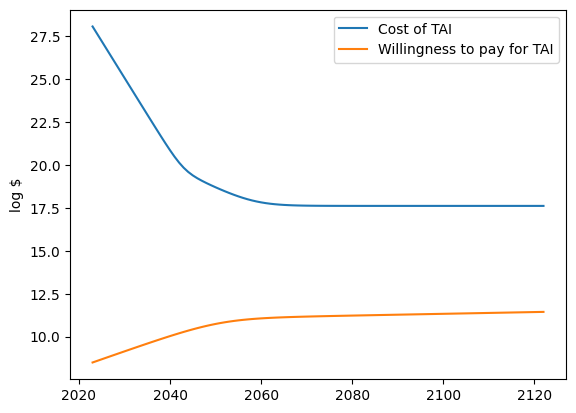

-
-
## SAMPLE RUN 20 ##
It takes 38.1 log FLOP (~126 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~485 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~382 million). This doubles every 2.4 years to a max of 0.041134% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.9 max log FLOP available - TAI takes 38.1 log FLOP - log 2023$USD 19.7 to buy TAI vs. willingness to pay log $ 8.6 - 18.4 log FLOP per $ (Total FLOP 26.9 vs. Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.2 max log FLOP available - TAI takes 37.8 log FLOP - log 2023$USD 19.3 to buy TAI vs. willingness to pay log $ 8.7 - 18.5 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.5)
Year: 2025 - 27.4 max log FLOP available - TAI

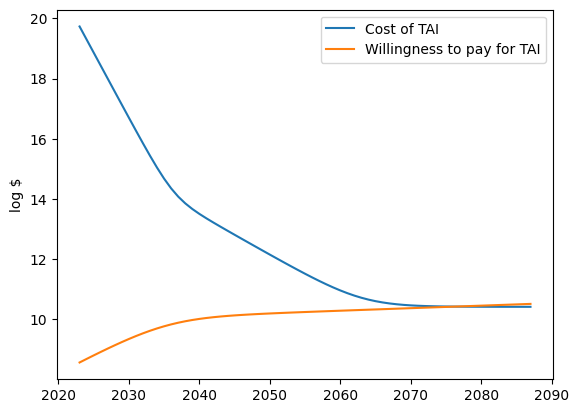

-
-
## SAMPLE RUN 21 ##
It takes 33.7 log FLOP (~5 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~122 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~243 million). This doubles every 3.2 years to a max of 0.03393% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.6 max log FLOP available - TAI takes 33.7 log FLOP - log 2023$USD 15.5 to buy TAI vs. willingness to pay log $ 8.4 - 18.2 log FLOP per $ (Total FLOP 26.6 vs. Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP available - TAI takes 33.6 log FLOP - log 2023$USD 15.2 to buy TAI vs. willingness to pay log $ 8.5 - 18.4 log FLOP per $ (Total FLOP 26.8 vs. Effective 2023-logFLOP: 27.0)
Year: 2025 - 27.1 max log FLOP available - TAI takes 33.

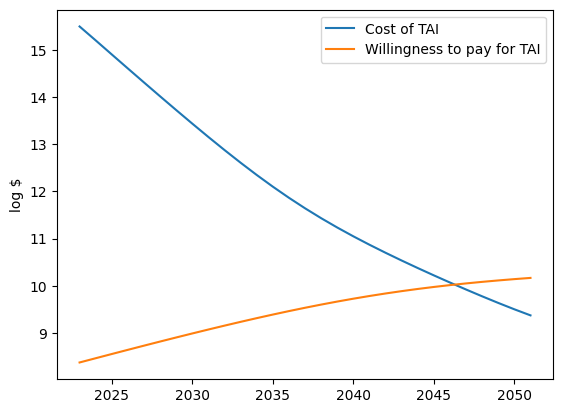

-
-
## SAMPLE RUN 22 ##
It takes 41.4 log FLOP (~251 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 3.2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~3 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 1.8 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.041x per year.
---
Year: 2023 - 27.0 max log FLOP available - TAI takes 41.4 log FLOP - log 2023$USD 23.0 to buy TAI vs. willingness to pay log $ 8.6 - 18.4 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.3 max log FLOP available - TAI takes 41.1 log FLOP - log 2023$USD 22.6 to buy TAI vs. willingness to pay log $ 8.8 - 18.5 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.6)
Year: 2025 - 27.6 max log FLOP available - TAI tak

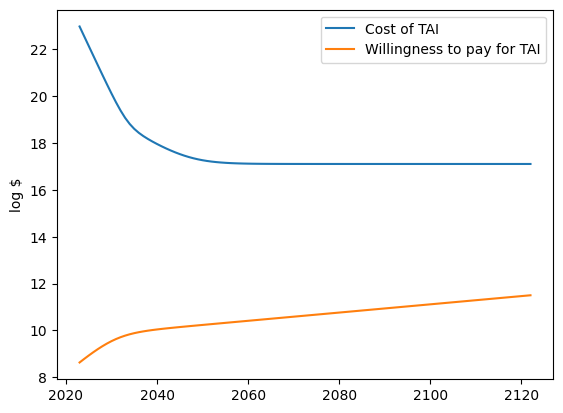

-
-
## SAMPLE RUN 23 ##
It takes 44.5 log FLOP (~316 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~50 septillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~569 million). This doubles every 1.3 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 27.1 max log FLOP available - TAI takes 44.5 log FLOP - log 2023$USD 26.1 to buy TAI vs. willingness to pay log $ 8.7 - 18.4 log FLOP per $ (Total FLOP 27.1 vs. Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.5 max log FLOP available - TAI takes 44.2 log FLOP - log 2023$USD 25.7 to buy TAI vs. willingness to pay log $ 8.9 - 18.5 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.8)
Year: 2025 - 27.8 max log FLOP available - TAI takes

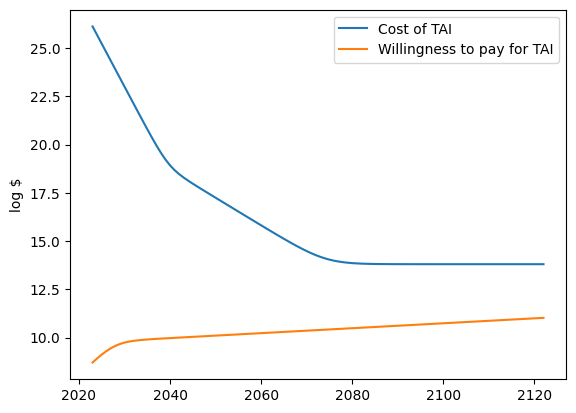

-
-
## SAMPLE RUN 24 ##
It takes 25.8 log FLOP (~63 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~624 million). This doubles every 3.1 years to a max of 0.248192% of GDP (initially ~57 billion 2022$USD). GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 27.1 max log FLOP available - TAI takes 25.8 log FLOP - log 2023$USD 7.5 to buy TAI vs. willingness to pay log $ 8.8 - 18.3 log FLOP per $ (Total FLOP 27.1 vs. Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> Nonscaling de

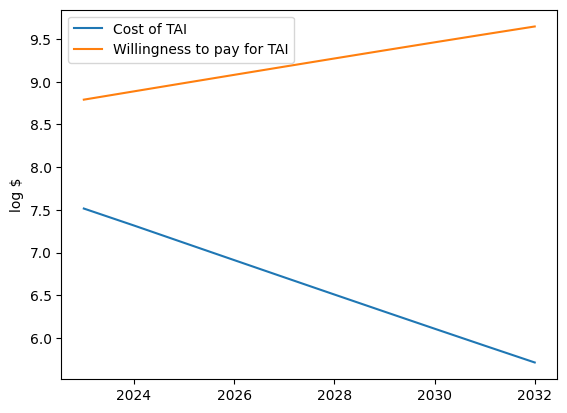

-
-
## SAMPLE RUN 25 ##
It takes 32.0 log FLOP (~100 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~469 million). This doubles every 1.0 years until 2025, and then doubles every 0.9 years to a max of 0.031974% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 27.6 max log FLOP available - TAI takes 32.0 log FLOP - log 2023$USD 13.1 to buy TAI vs. willingness to pay log $ 8.6 - 18.9 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.6)
Year: 2024 - 28.0 max log FLOP available - TAI takes 31.9 log FLOP - log 2023$USD 12.8 to buy TAI vs. willingness to pay log $ 8.9 - 19.1 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.2)
Year: 2025

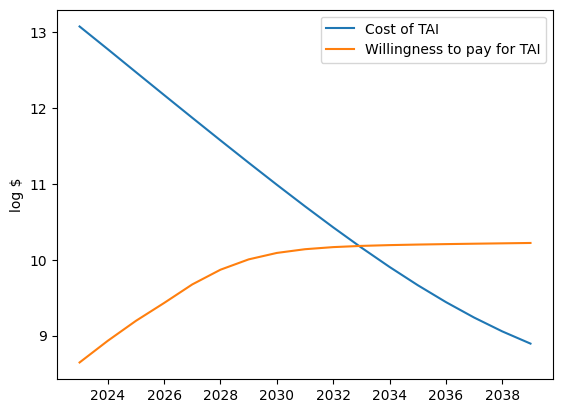

-
-
## SAMPLE RUN 26 ##
It takes 37.0 log FLOP (~10 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 20.7 log FLOP (~542 quintillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~243 million). This doubles every 2.5 years to a max of 0.031461% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.7 max log FLOP available - TAI takes 37.0 log FLOP - log 2023$USD 18.6 to buy TAI vs. willingness to pay log $ 8.4 - 18.4 log FLOP per $ (Total FLOP 26.7 vs. Effective 2023-logFLOP: 26.7)
Year: 2024 - 27.0 max log FLOP available - TAI takes 36.7 log FLOP - log 2023$USD 18.2 to buy TAI vs. willingness to pay log $ 8.5 - 18.5 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.3)
Year: 2025 - 27.2 max log FLOP available - T

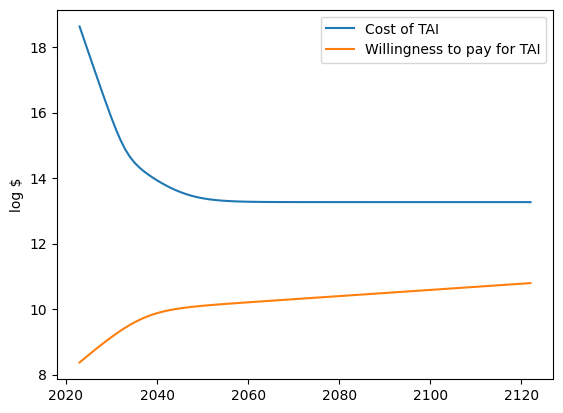

-
-
## SAMPLE RUN 27 ##
It takes 26.2 log FLOP (~158 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.2 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~3 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~385 million). This doubles every 3.0 years to a max of 0.051191% of GDP (initially ~12 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.8 max log FLOP available - TAI takes 26.2 log FLOP - log 2023$USD 8.0 to buy TAI vs. willingness to pay log $ 8.6 - 18.2 log FLOP per $ (Total FLOP 26.8 vs. Effective 2023-logFLOP: 26.8)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
-- robot

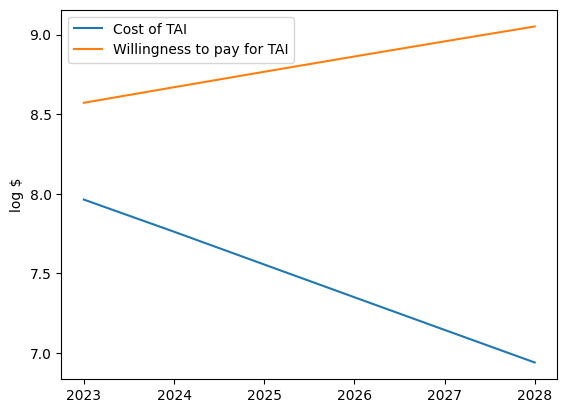

-
-
## SAMPLE RUN 28 ##
It takes 31.2 log FLOP (~16 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~158 million). This doubles every 2.0 years to a max of 0.237255% of GDP (initially ~55 billion 2022$USD). GDP grows at a rate of 1.038x per year.
---
Year: 2023 - 26.6 max log FLOP available - TAI takes 31.2 log FLOP - log 2023$USD 12.8 to buy TAI vs. willingness to pay log $ 8.2 - 18.4 log FLOP per $ (Total FLOP 26.6 vs. Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.9 max log FLOP available - TAI takes 31.1 log FLOP - log 2023$USD 12.6 to buy TAI vs. willingness to pay log $ 8.4 - 18.5 log FLOP per $ (Total FLOP 26.9 vs. Effective 2023-logFLOP: 27.0)
Year: 2025 - 27.1 max log FLOP available - TAI takes 31

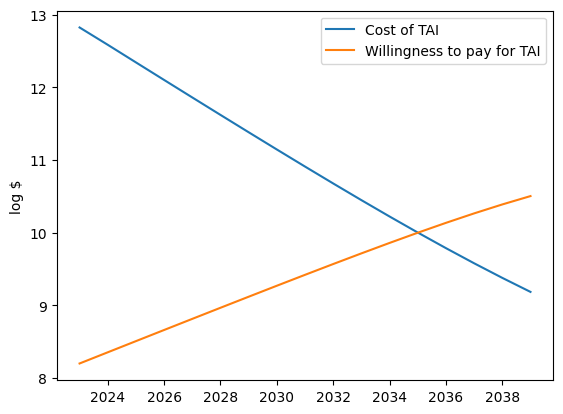

-
-
## SAMPLE RUN 29 ##
It takes 32.2 log FLOP (~158 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~397 million). This doubles every 2.7 years to a max of 1.026758% of GDP (initially ~236 billion 2022$USD). GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.3 max log FLOP available - TAI takes 32.2 log FLOP - log 2023$USD 13.5 to buy TAI vs. willingness to pay log $ 8.6 - 18.7 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.5 max log FLOP available - TAI takes 32.1 log FLOP - log 2023$USD 13.3 to buy TAI vs. willingness to pay log $ 8.7 - 18.8 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.6)
Year: 2025 - 27.7 max log FLOP available - TAI takes 

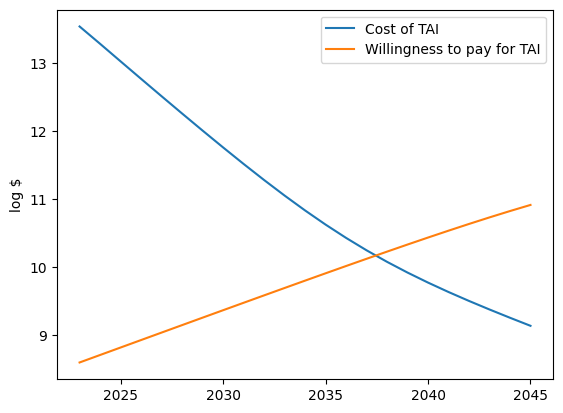

-
-
## SAMPLE RUN 30 ##
It takes 27.9 log FLOP (~8 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 2.2 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.9 max log FLOP available - TAI takes 27.9 log FLOP - log 2023$USD 9.8 to buy TAI vs. willingness to pay log $ 8.8 - 18.1 log FLOP per $ (Total FLOP 26.9 vs. Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.2 max log FLOP available - TAI takes 27.8 log FLOP - log 2023$USD 9.6 to buy TAI vs. willingness to pay log $ 8.9 - 18.2 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.2)
Year: 2025 - 27.4 max log FLOP available - TAI takes 27.7 log FL

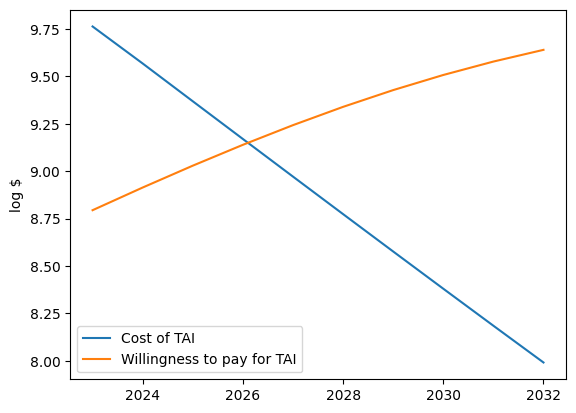

-
-
## SAMPLE RUN 31 ##
It takes 35.1 log FLOP (~126 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.8 log FLOP (~6 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~36 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 3.0 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 27.8 max log FLOP available - TAI takes 35.1 log FLOP - log 2023$USD 16.3 to buy TAI vs. willingness to pay log $ 9.0 - 18.8 log FLOP per $ (Total FLOP 27.8 vs. Effective 2023-logFLOP: 27.8)
Year: 2024 - 28.0 max log FLOP available - TAI takes 34.9 log FLOP - log 2023$USD 16.0 to buy TAI vs. willingness to pay log $ 9.1 - 18.9 log FLOP per $ (Total FLOP 28.0 vs. Effective 2023-logFLOP: 28.2)
Year: 2025 - 28.2 max log FLOP available - TAI takes 34.7 l

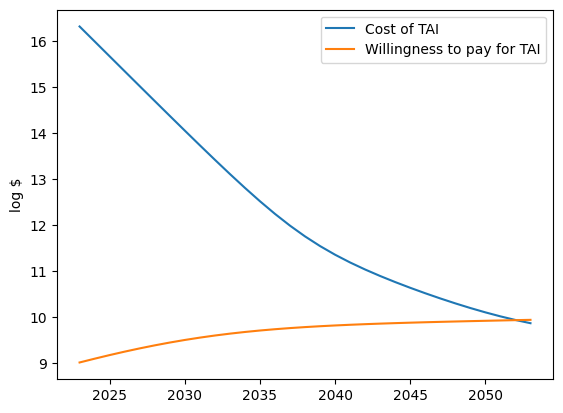

-
-
## SAMPLE RUN 32 ##
It takes 32.6 log FLOP (~398 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.1 log FLOP (~12 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~28 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 3.3 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 27.4 max log FLOP available - TAI takes 32.6 log FLOP - log 2023$USD 13.5 to buy TAI vs. willingness to pay log $ 8.3 - 19.1 log FLOP per $ (Total FLOP 27.4 vs. Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.6 max log FLOP available - TAI takes 32.5 log FLOP - log 2023$USD 13.2 to buy TAI vs. willingness to pay log $ 8.4 - 19.2 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.7)
Year: 2025 - 27.8 max log FLOP available - TAI takes 32.

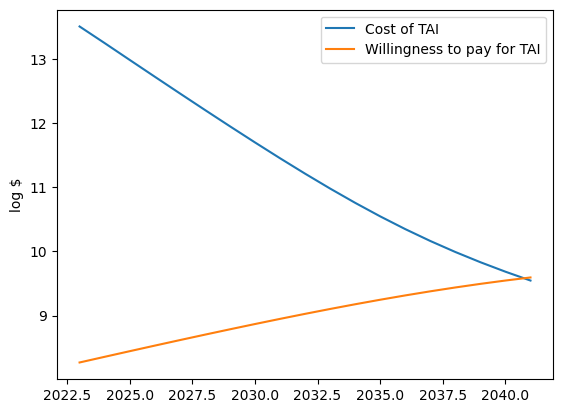

-
-
## SAMPLE RUN 33 ##
It takes 26.0 log FLOP (~100 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~3 septillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 2.7 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.033x per year.
---
Year: 2023 - 27.3 max log FLOP available - TAI takes 26.0 log FLOP - log 2023$USD 7.3 to buy TAI vs. willingness to pay log $ 8.6 - 18.7 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.3)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 7 years)
-- data p_nonscaling_issue p=0.0 ->

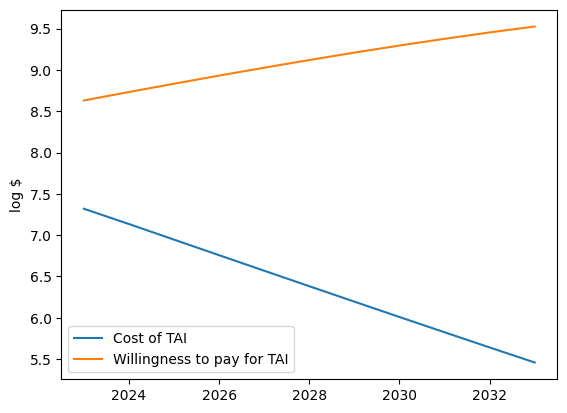

-
-
## SAMPLE RUN 34 ##
It takes 28.6 log FLOP (~40 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5 septillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 1.3 years to a max of 0.034546% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.1 max log FLOP available - TAI takes 28.6 log FLOP - log 2023$USD 10.5 to buy TAI vs. willingness to pay log $ 9.0 - 18.1 log FLOP per $ (Total FLOP 27.1 vs. Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.4 max log FLOP available - TAI takes 28.5 log FLOP - log 2023$USD 10.2 to buy TAI vs. willingness to pay log $ 9.2 - 18.3 log FLOP per $ (Total FLOP 27.4 vs. Effective 2023-logFLOP: 27.5)
Year: 2025 - 27.8 max log FLOP available - TAI takes 28.4 

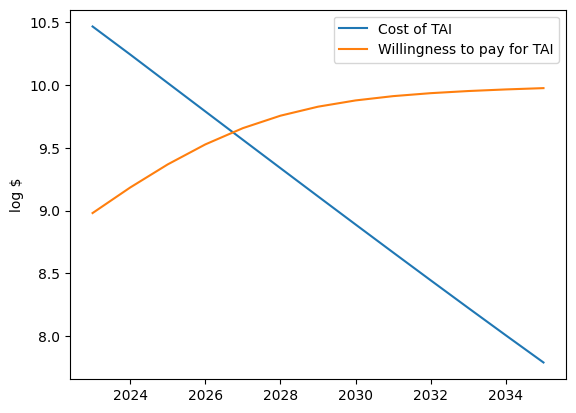

-
-
## SAMPLE RUN 35 ##
It takes 39.0 log FLOP (~1 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.1 log FLOP (~1 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~56 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~790 million). This doubles every 4.0 years to a max of 0.693203% of GDP (initially ~159 billion 2022$USD). GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 27.0 max log FLOP available - TAI takes 39.0 log FLOP - log 2023$USD 20.9 to buy TAI vs. willingness to pay log $ 8.9 - 18.1 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP available - TAI takes 38.7 log FLOP - log 2023$USD 20.5 to buy TAI vs. willingness to pay log $ 9.0 - 18.2 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.5)
Year: 2025 - 27.4 max log FLOP available - TAI t

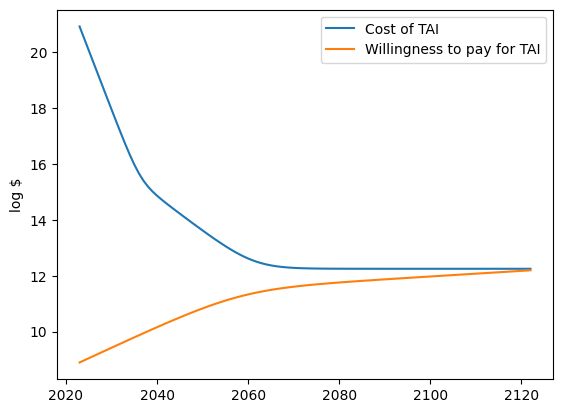

-
-
## SAMPLE RUN 36 ##
It takes 27.0 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~96 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~757 million). This doubles every 3.7 years to a max of 0.069492% of GDP (initially ~16 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 27.4 max log FLOP available - TAI takes 27.0 log FLOP - log 2023$USD 8.5 to buy TAI vs. willingness to pay log $ 8.9 - 18.5 log FLOP per $ (Total FLOP 27.4 vs. Effective 2023-logFLOP: 27.4)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 7 years)
-- data p_nonscaling_issue p=0.0 

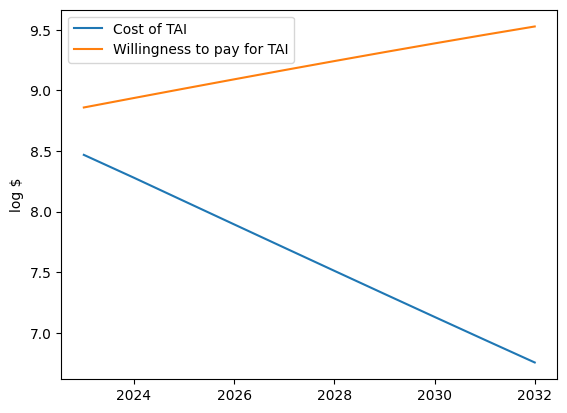

-
-
## SAMPLE RUN 37 ##
It takes 47.3 log FLOP (~200 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 6 log reductions possible.
FLOP start at a cost of 18.4 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~157 million). This doubles every 4.4 years to a max of 0.082827% of GDP (initially ~19 billion 2022$USD). GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.5 max log FLOP available - TAI takes 47.3 log FLOP - log 2023$USD 28.9 to buy TAI vs. willingness to pay log $ 8.2 - 18.4 log FLOP per $ (Total FLOP 26.5 vs. Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.8 max log FLOP available - TAI takes 47.0 log FLOP - log 2023$USD 28.5 to buy TAI vs. willingness to pay log $ 8.3 - 18.5 log FLOP per $ (Total FLOP 26.8 vs. Effective 2023-logFLOP: 27.1)
Year: 2025 - 27.0 max log FLOP available - TAI 

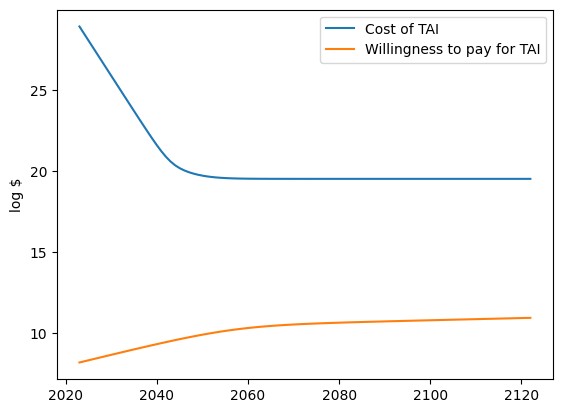

-
-
## SAMPLE RUN 38 ##
It takes 32.8 log FLOP (~631 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~74 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~314 million). This doubles every 1.0 years to a max of 0.21364% of GDP (initially ~49 billion 2022$USD). GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.1 max log FLOP available - TAI takes 32.8 log FLOP - log 2023$USD 14.2 to buy TAI vs. willingness to pay log $ 8.5 - 18.6 log FLOP per $ (Total FLOP 27.1 vs. Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.5 max log FLOP available - TAI takes 32.7 log FLOP - log 2023$USD 13.9 to buy TAI vs. willingness to pay log $ 8.8 - 18.7 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.7)
Year: 2025 - 27.9 max log FLOP available - TAI takes 3

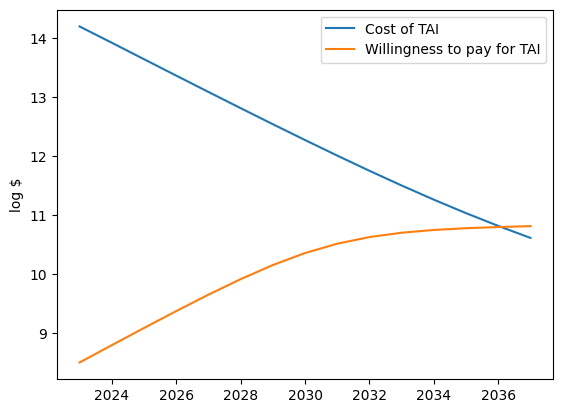

-
-
## SAMPLE RUN 39 ##
It takes 31.5 log FLOP (~32 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.7 log FLOP (~5 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5 septillion) per 2022$USD.
We are initially willing to pay 9.6 log 2022$USD (~4 billion). This doubles every 2.1 years to a max of 0.048329% of GDP (initially ~11 billion 2022$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 28.2 max log FLOP available - TAI takes 31.5 log FLOP - log 2023$USD 12.8 to buy TAI vs. willingness to pay log $ 9.5 - 18.7 log FLOP per $ (Total FLOP 28.2 vs. Effective 2023-logFLOP: 28.2)
Year: 2024 - 28.4 max log FLOP available - TAI takes 31.4 log FLOP - log 2023$USD 12.5 to buy TAI vs. willingness to pay log $ 9.6 - 18.8 log FLOP per $ (Total FLOP 28.4 vs. Effective 2023-logFLOP: 28.5)
Year: 2025 - 28.6 max log FLOP available - TAI takes 31.3

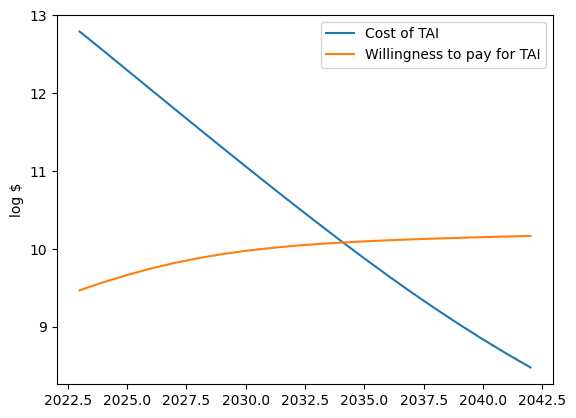

-
-
## SAMPLE RUN 40 ##
It takes 33.2 log FLOP (~2 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~116 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~605 million). This doubles every 7.5 years to a max of 0.064159% of GDP (initially ~15 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.3 max log FLOP available - TAI takes 33.2 log FLOP - log 2023$USD 14.7 to buy TAI vs. willingness to pay log $ 8.8 - 18.5 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.4 max log FLOP available - TAI takes 33.1 log FLOP - log 2023$USD 14.4 to buy TAI vs. willingness to pay log $ 8.8 - 18.6 log FLOP per $ (Total FLOP 27.4 vs. Effective 2023-logFLOP: 27.6)
Year: 2025 - 27.6 max log FLOP available - TAI takes 3

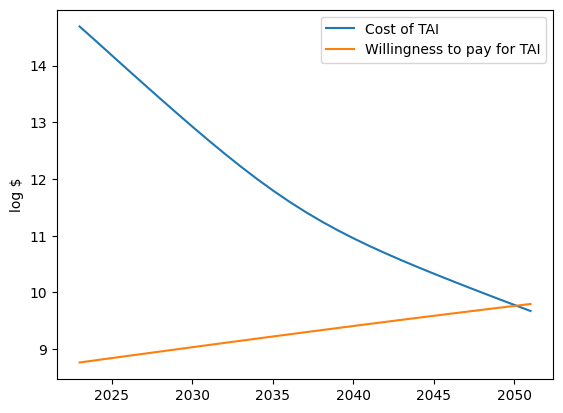

-
-
## SAMPLE RUN 41 ##
It takes 26.8 log FLOP (~631 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.0 log FLOP (~1 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~24 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~569 million). This doubles every 1.4 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 26.7 max log FLOP available - TAI takes 26.8 log FLOP - log 2023$USD 8.8 to buy TAI vs. willingness to pay log $ 8.7 - 18.0 log FLOP per $ (Total FLOP 26.7 vs. Effective 2023-logFLOP: 26.7)
Year: 2024 - 27.0 max log FLOP available - TAI takes 26.7 log FLOP - log 2023$USD 8.6 to buy TAI vs. willingness to pay log $ 8.9 - 18.1 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.1)
-- algorithms p_nonscaling_issue p=0.3428 -> Nonscaling issu

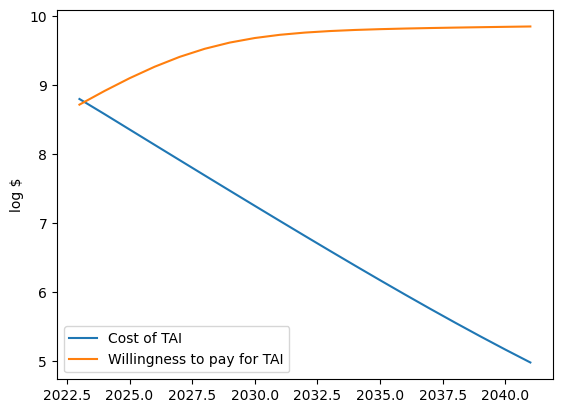

-
-
## SAMPLE RUN 42 ##
It takes 39.1 log FLOP (~1 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 2.2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~128 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 3.3 years to a max of 0.025% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.4 max log FLOP available - TAI takes 39.1 log FLOP - log 2023$USD 20.8 to buy TAI vs. willingness to pay log $ 8.1 - 18.3 log FLOP per $ (Total FLOP 26.4 vs. Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP available - TAI takes 38.8 log FLOP - log 2023$USD 20.4 to buy TAI vs. willingness to pay log $ 8.2 - 18.4 log FLOP per $ (Total FLOP 26.6 vs. Effective 2023-logFLOP: 26.9)
Year: 2025 - 26.8 max log FLOP available - TAI take

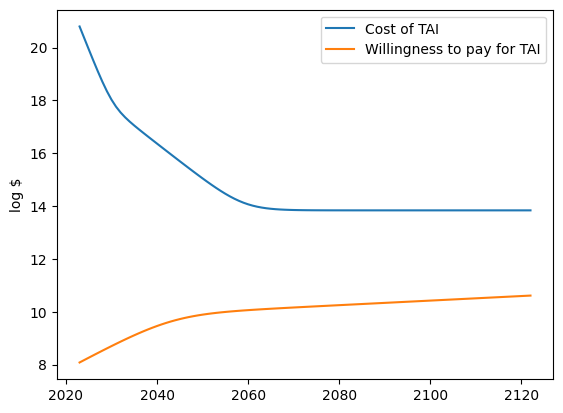

-
-
## SAMPLE RUN 43 ##
It takes 36.1 log FLOP (~1 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~251 million). This doubles every 5.5 years to a max of 0.455633% of GDP (initially ~105 billion 2022$USD). GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 27.0 max log FLOP available - TAI takes 36.1 log FLOP - log 2023$USD 17.5 to buy TAI vs. willingness to pay log $ 8.4 - 18.6 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP available - TAI takes 35.8 log FLOP - log 2023$USD 17.1 to buy TAI vs. willingness to pay log $ 8.5 - 18.7 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.5)
Year: 2025 - 27.3 max log FLOP available - TAI

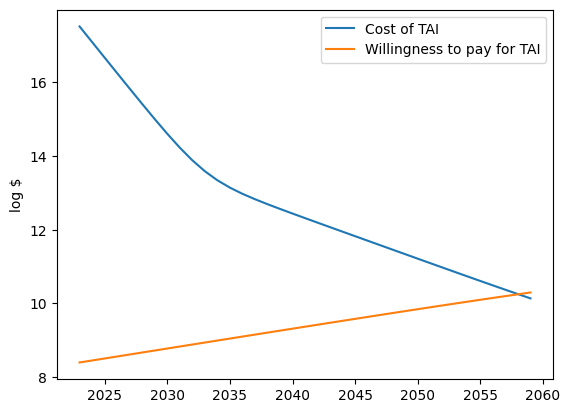

-
-
## SAMPLE RUN 44 ##
It takes 33.3 log FLOP (~2 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~31 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~124 million). This doubles every 3.8 years to a max of 0.048211% of GDP (initially ~11 billion 2022$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.6 max log FLOP available - TAI takes 33.3 log FLOP - log 2023$USD 14.8 to buy TAI vs. willingness to pay log $ 8.1 - 18.5 log FLOP per $ (Total FLOP 26.6 vs. Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP available - TAI takes 33.2 log FLOP - log 2023$USD 14.5 to buy TAI vs. willingness to pay log $ 8.2 - 18.6 log FLOP per $ (Total FLOP 26.8 vs. Effective 2023-logFLOP: 26.9)
Year: 2025 - 27.0 max log FLOP available - TAI takes 33.

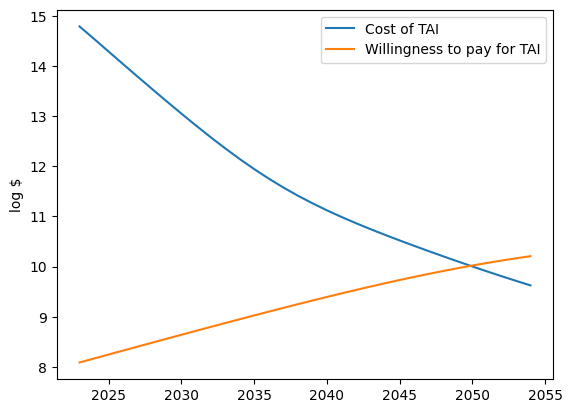

-
-
## SAMPLE RUN 45 ##
It takes 30.3 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 25.8 log FLOP (~68 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~379 million). This doubles every 5.3 years to a max of 0.034072% of GDP (initially ~8 billion 2022$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.8 max log FLOP available - TAI takes 30.3 log FLOP - log 2023$USD 12.0 to buy TAI vs. willingness to pay log $ 8.6 - 18.3 log FLOP per $ (Total FLOP 26.8 vs. Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP available - TAI takes 30.2 log FLOP - log 2023$USD 11.8 to buy TAI vs. willingness to pay log $ 8.6 - 18.4 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.1)
Year: 2025 - 27.2 max log FLOP available - TAI takes 30.

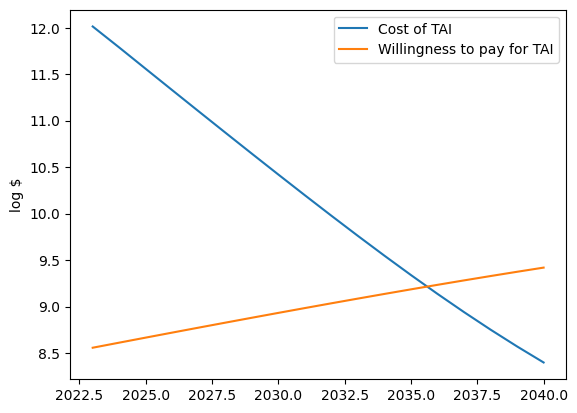

-
-
## SAMPLE RUN 46 ##
It takes 27.0 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 17.8 log FLOP (~647 quadrillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 26.2 log FLOP (~159 septillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~307 million). This doubles every 5.0 years to a max of 0.044675% of GDP (initially ~10 billion 2022$USD). GDP grows at a rate of 1.036x per year.
---
Year: 2023 - 26.3 max log FLOP available - TAI takes 27.0 log FLOP - log 2023$USD 9.2 to buy TAI vs. willingness to pay log $ 8.5 - 17.8 log FLOP per $ (Total FLOP 26.3 vs. Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.5 max log FLOP available - TAI takes 26.9 log FLOP - log 2023$USD 9.0 to buy TAI vs. willingness to pay log $ 8.5 - 17.9 log FLOP per $ (Total FLOP 26.5 vs. Effective 2023-logFLOP: 26.6)
Year: 2025 - 26.6 max log FLOP available - TAI takes 26.

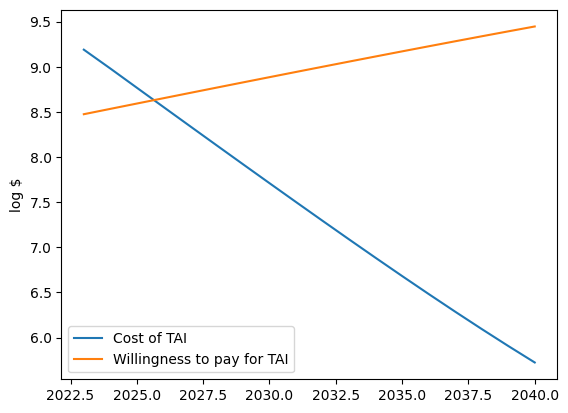

-
-
## SAMPLE RUN 47 ##
It takes 24.0 log FLOP (~1000 sextillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 19.2 log FLOP (~16 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~100 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~248 million). This doubles every 4.6 years to a max of 0.078084% of GDP (initially ~18 billion 2022$USD). GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.6 max log FLOP available - TAI takes 24.0 log FLOP - log 2023$USD 4.8 to buy TAI vs. willingness to pay log $ 8.4 - 19.2 log FLOP per $ (Total FLOP 27.6 vs. Effective 2023-logFLOP: 27.6)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 6 years)
-- data p_nonscaling_issue 

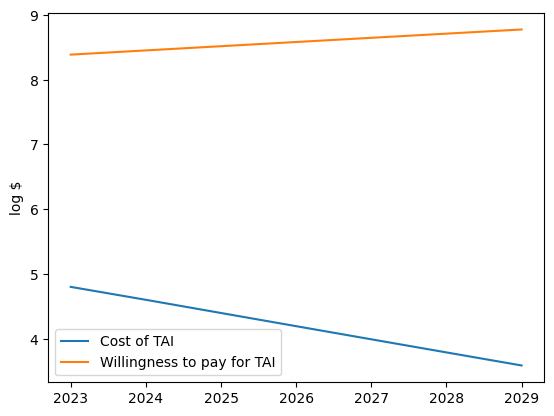

-
-
## SAMPLE RUN 48 ##
It takes 34.3 log FLOP (~20 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~496 million). This doubles every 3.5 years to a max of 0.197675% of GDP (initially ~45 billion 2022$USD). GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.0 max log FLOP available - TAI takes 34.3 log FLOP - log 2023$USD 16.0 to buy TAI vs. willingness to pay log $ 8.7 - 18.3 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP available - TAI takes 34.1 log FLOP - log 2023$USD 15.7 to buy TAI vs. willingness to pay log $ 8.8 - 18.4 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.4)
Year: 2025 - 27.4 max log FLOP available - TAI takes 33

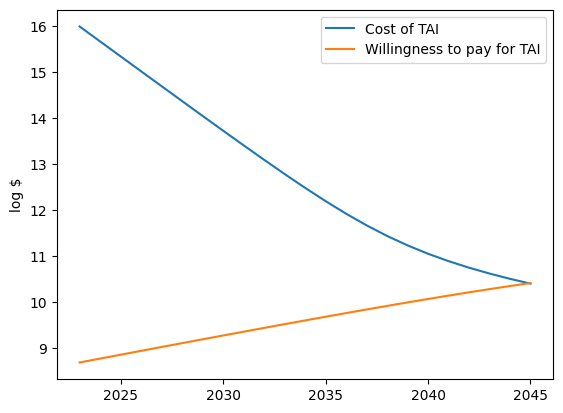

-
-
## SAMPLE RUN 49 ##
It takes 33.1 log FLOP (~1 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~38 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~157 million). This doubles every 1.1 years to a max of 0.05877% of GDP (initially ~14 billion 2022$USD). GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.7 max log FLOP available - TAI takes 33.1 log FLOP - log 2023$USD 14.6 to buy TAI vs. willingness to pay log $ 8.2 - 18.5 log FLOP per $ (Total FLOP 26.7 vs. Effective 2023-logFLOP: 26.7)
Year: 2024 - 27.0 max log FLOP available - TAI takes 33.0 log FLOP - log 2023$USD 14.4 to buy TAI vs. willingness to pay log $ 8.5 - 18.6 log FLOP per $ (Total FLOP 27.0 vs. Effective 2023-logFLOP: 27.2)
Year: 2025 - 27.4 max log FLOP available - TAI takes 32.

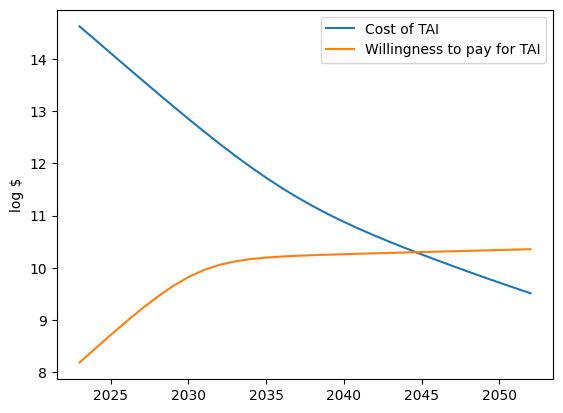

-
-
## SAMPLE RUN 50 ##
It takes 34.3 log FLOP (~20 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~573 million). This doubles every 2.8 years to a max of 0.026904% of GDP (initially ~6 billion 2022$USD). GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.3 max log FLOP available - TAI takes 34.3 log FLOP - log 2023$USD 15.7 to buy TAI vs. willingness to pay log $ 8.7 - 18.6 log FLOP per $ (Total FLOP 27.3 vs. Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.5 max log FLOP available - TAI takes 34.1 log FLOP - log 2023$USD 15.4 to buy TAI vs. willingness to pay log $ 8.8 - 18.7 log FLOP per $ (Total FLOP 27.5 vs. Effective 2023-logFLOP: 27.7)
Year: 2025 - 27.7 max log FLOP available - TAI takes 33

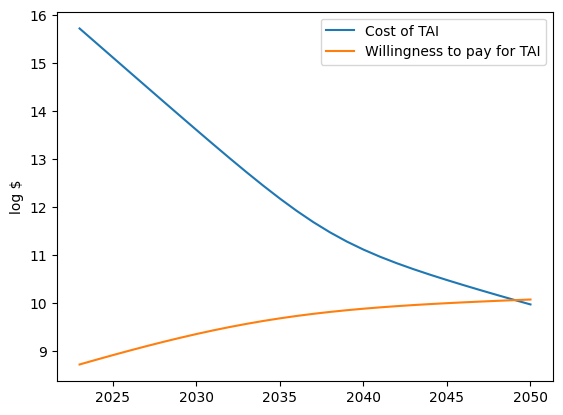

-
-
## SAMPLE RUN 51 ##
It takes 35.6 log FLOP (~398 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.9 log FLOP (~8 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~16 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~195 million). This doubles every 1.6 years to a max of 0.038376% of GDP (initially ~9 billion 2022$USD). GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 27.2 max log FLOP available - TAI takes 35.6 log FLOP - log 2023$USD 16.7 to buy TAI vs. willingness to pay log $ 8.3 - 18.9 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP available - TAI takes 35.4 log FLOP - log 2023$USD 16.4 to buy TAI vs. willingness to pay log $ 8.5 - 19.0 log FLOP per $ (Total FLOP 27.4 vs. Effective 2023-logFLOP: 27.6)
Year: 2025 - 27.7 max log FLOP available - TAI takes 35

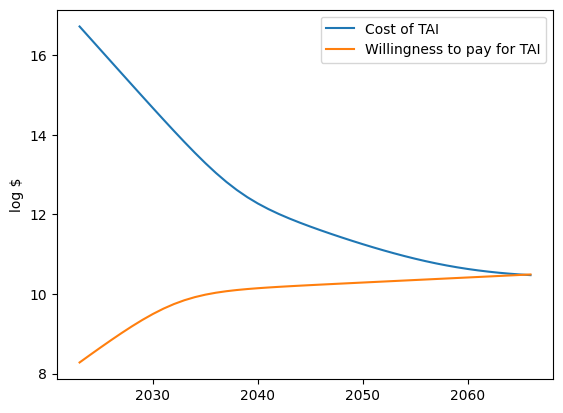

-
-
## SAMPLE RUN 52 ##
It takes 25.6 log FLOP (~40 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.6 log FLOP (~4 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~144 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~197 million). This doubles every 3.2 years to a max of 0.078834% of GDP (initially ~18 billion 2022$USD). GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.9 max log FLOP available - TAI takes 25.6 log FLOP - log 2023$USD 7.0 to buy TAI vs. willingness to pay log $ 8.3 - 18.6 log FLOP per $ (Total FLOP 26.9 vs. Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.4 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 6 years)
-- data p_nonscaling_issue p=0

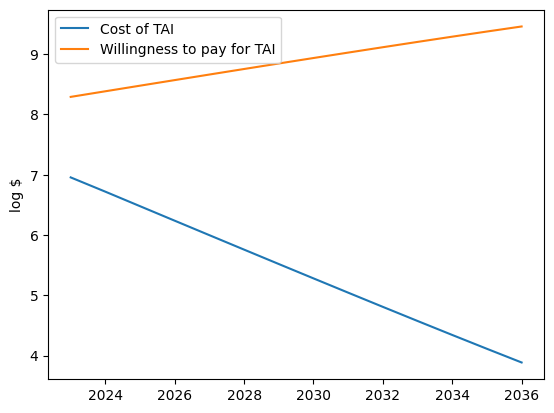

-
-
## SAMPLE RUN 53 ##
It takes 30.0 log FLOP (~1 nonillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.5 log FLOP (~3 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~841 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~377 million). This doubles every 8.7 years to a max of 0.030694% of GDP (initially ~7 billion 2022$USD). GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.1 max log FLOP available - TAI takes 30.0 log FLOP - log 2023$USD 11.5 to buy TAI vs. willingness to pay log $ 8.6 - 18.5 log FLOP per $ (Total FLOP 27.1 vs. Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.2 max log FLOP available - TAI takes 29.9 log FLOP - log 2023$USD 11.2 to buy TAI vs. willingness to pay log $ 8.6 - 18.7 log FLOP per $ (Total FLOP 27.2 vs. Effective 2023-logFLOP: 27.3)
Year: 2025 - 27.4 max log FLOP available - TAI takes 29

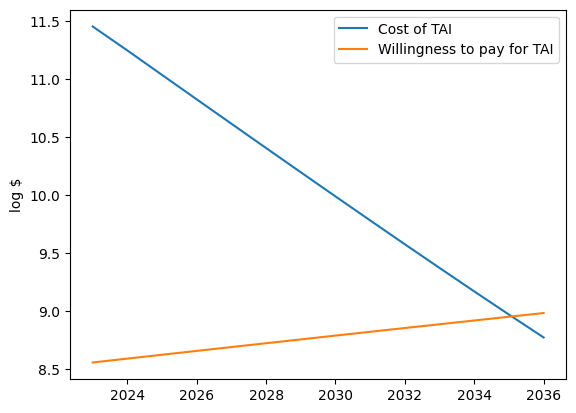

In [14]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [15]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2023-10-05 21:49:21.562347
